In [1]:
from pathlib import Path

import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from plot_functions import auto_plot_style
from plot_functions import normhist, normhist2d
from core_functions import progressbar

from invisible_cities.core.core_functions import in_range, shift_to_bin_centers
from invisible_cities.core. fit_functions import fit, gauss, expo
from invisible_cities.cities.components   import deconv_pmt, calibrate_pmts
from invisible_cities.database.load_db    import DataPMT

In [2]:
%matplotlib inline
auto_plot_style()

In [ ]:
# This are selected rwfs of Kr events at very low radius to miminize
# the impact of energy corrections in the shape of the waveform
path = Path("/media/gonzalo/se/data/NEXT/next100/15539-kr-nozs/selected/")
filenames = sorted(path.glob("selected*.h5"))
len(filenames)

In [63]:
datapmt   = DataPMT("next100", 15539)
active    = datapmt.Active.values == 1
activepmt = datapmt.loc[ active]
maskedpmt = datapmt.loc[~active]

deconv = deconv_pmt("next100", 15539, 1600*40)
calib  = calibrate_pmts("next100", 15539, 100, 3)

# Integrate empty windows

In [15]:
cache = path / "noise.h5"

In [26]:
# ~ 30 min runtime
windows   = np.append([1], np.arange(10, 101, 5))
if not cache.exists():
    pmtlabels = [f"pmt_{sid}" for sid in sorted(datapmt.SensorID.loc[active].values)]
    dataint   = []
    for filename in progressbar(filenames):
        with tb.open_file(filename) as file:
            pmtrwf = file.root.RD.pmtrwf
            events = file.root.evtmap.read(field="evt_number")
            for evt, wfs in zip(events, pmtrwf):
                wfs = wfs[active, :]
                wfs = deconv(wfs)
                wfs, _, wfsum, _ = calib(wfs)
                t   = np.arange(len(wfsum)) * 25e-3

                for i in range(8):
                    sz  = np.random.choice(windows)
                    t0  = np.random.uniform(0, 1200)
                    sel = in_range(t, t0, t0+sz)

                    perpmt = wfs  [:, sel].sum(axis=1)
                    pmtsum = wfsum[   sel].sum()

                    d = dict( ( (   "evt",    evt)
                              , (    "sz",     sz)
                              , ("pmtsum", pmtsum)
                              , *zip(pmtlabels, perpmt)
                              ))
                    dataint.append(pd.DataFrame(d, index=[0]))

    dataint = pd.concat(dataint, ignore_index=True)
    dataint.to_hdf(cache, "/noise", complib="zlib", complevel=4, mode="w")
dataint = pd.read_hdf(cache, "/noise")

Item 109 of 109 | 16.37 s/item | ETA 0.3 min | Ellapsed 29.5 min


In [27]:
dataint

,evt,sz,pmtsum,pmt_0,pmt_1,pmt_2,pmt_4,pmt_5,pmt_6,pmt_7,...,pmt_46,pmt_47,pmt_49,pmt_51,pmt_52,pmt_54,pmt_55,pmt_56,pmt_57,pmt_59
0,393,50,53.666124,1.723721,-0.353001,0.862585,-1.688861,-0.027895,1.232023,-3.115048,...,5.597393,-1.027406,3.421537,-2.087007,4.665939,2.784439,4.134637,0.266904,-2.364964,4.260807
1,393,100,61.659637,-1.786212,1.783961,0.762372,-0.227552,1.435458,-2.405190,4.297975,...,0.877879,0.526616,-0.520274,-5.248497,-0.084868,2.773683,2.620829,2.537263,-7.372516,-1.862793
2,393,10,13.381752,0.825918,-0.311768,-0.180927,-0.510078,-0.248252,0.897398,0.313241,...,0.283853,-0.450734,-0.440567,0.273907,1.472831,0.715851,1.610455,0.367728,0.067188,-0.025985
3,393,30,-47.998528,1.472072,0.893082,-3.390712,-0.766942,-3.721924,0.506671,-3.171864,...,-0.953297,-0.513716,-1.817873,2.977428,-0.153450,0.830675,0.336470,-0.599857,0.178143,-0.533177
4,393,85,126.382354,3.046099,-2.808632,1.083755,0.391577,0.767027,-5.526492,3.195334,...,2.274853,5.448324,2.831723,3.681511,3.514262,7.279601,2.845185,2.661901,8.363193,4.630259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87171,1572935,20,-5.563225,-0.400477,-0.768441,-0.189973,-0.078094,1.051749,4.688508,-0.063230,...,-1.456098,-0.564459,1.702596,-3.509497,1.022663,2.499863,0.351254,-0.656721,-0.195941,1.423828
87172,1572935,50,5.767820,2.566187,-0.685908,-0.924459,-0.817301,2.198740,-1.783544,-1.608482,...,2.872051,4.076329,-1.927904,6.183445,1.773491,-1.034746,-1.977326,3.350663,2.956467,1.989254
87173,1572935,95,-64.012281,-4.359955,2.681488,4.551227,-0.717010,1.363468,-4.115627,-3.775708,...,-3.778204,1.596014,-4.177061,-0.759602,-1.625599,-9.055277,3.563349,-0.414108,-10.130400,4.452023
87174,1572935,35,32.632509,1.497653,2.491970,1.061778,2.420314,4.467217,-1.744948,-3.694008,...,1.602154,3.607669,-3.258916,2.952933,1.278171,1.241371,0.405957,2.363651,2.114636,4.243334


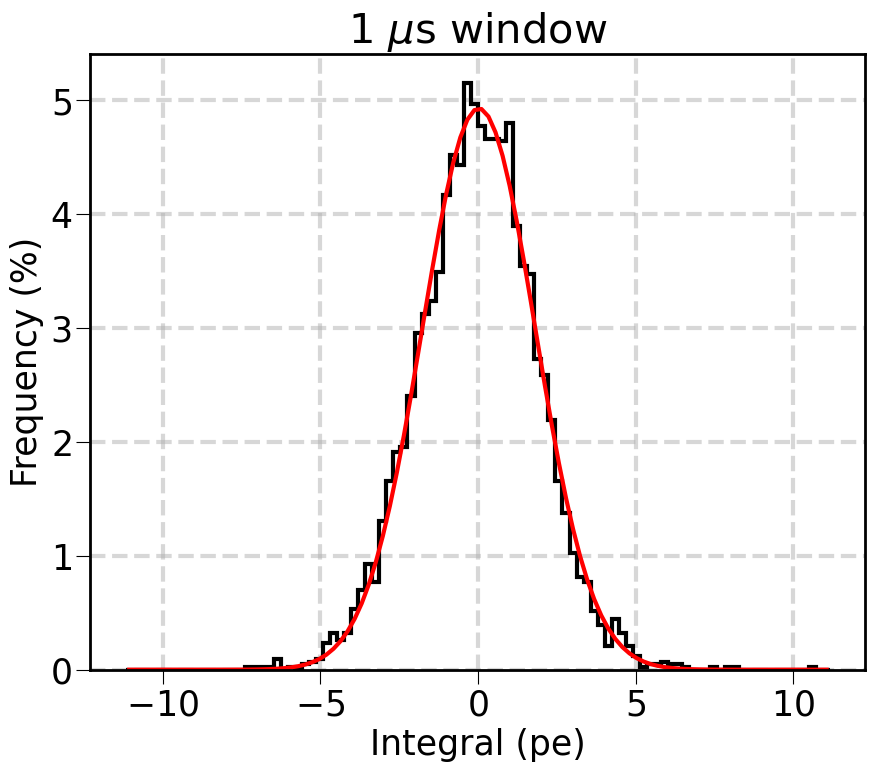

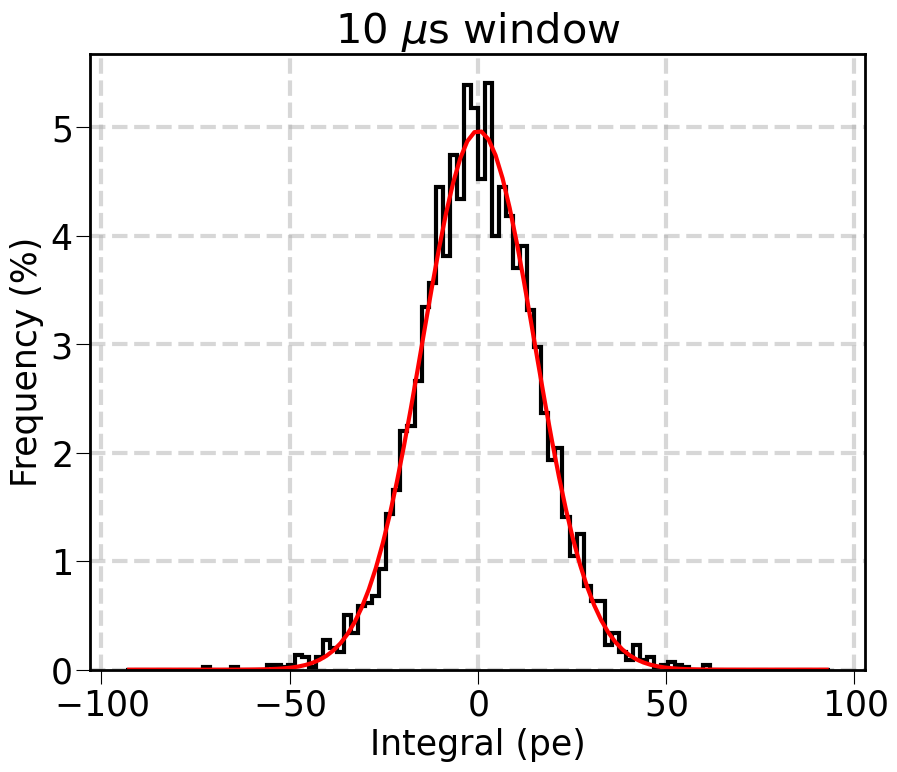

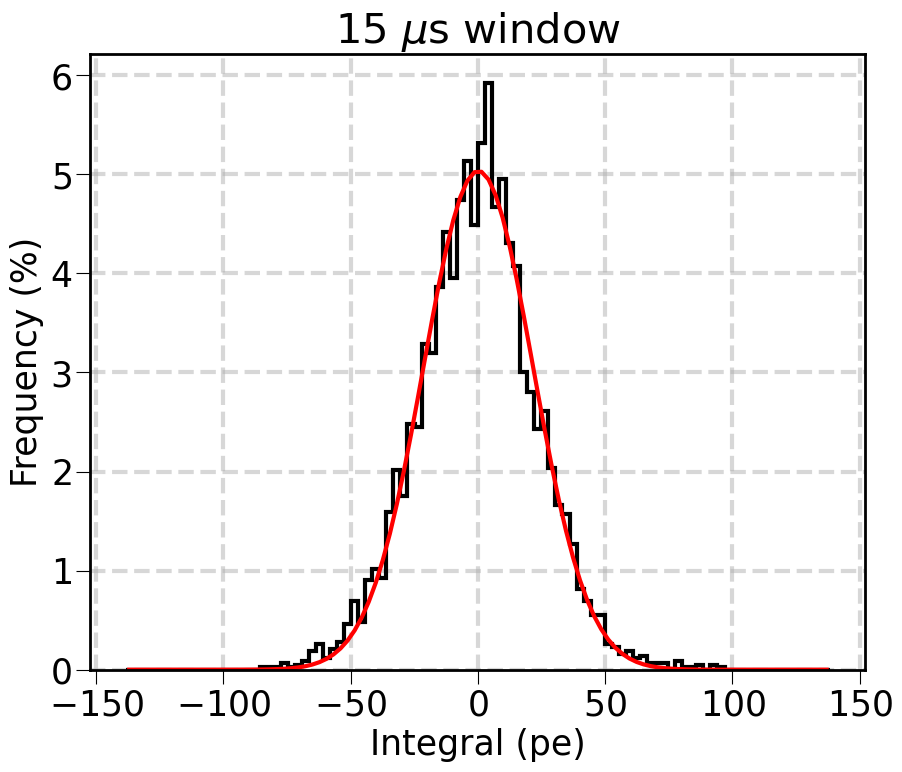

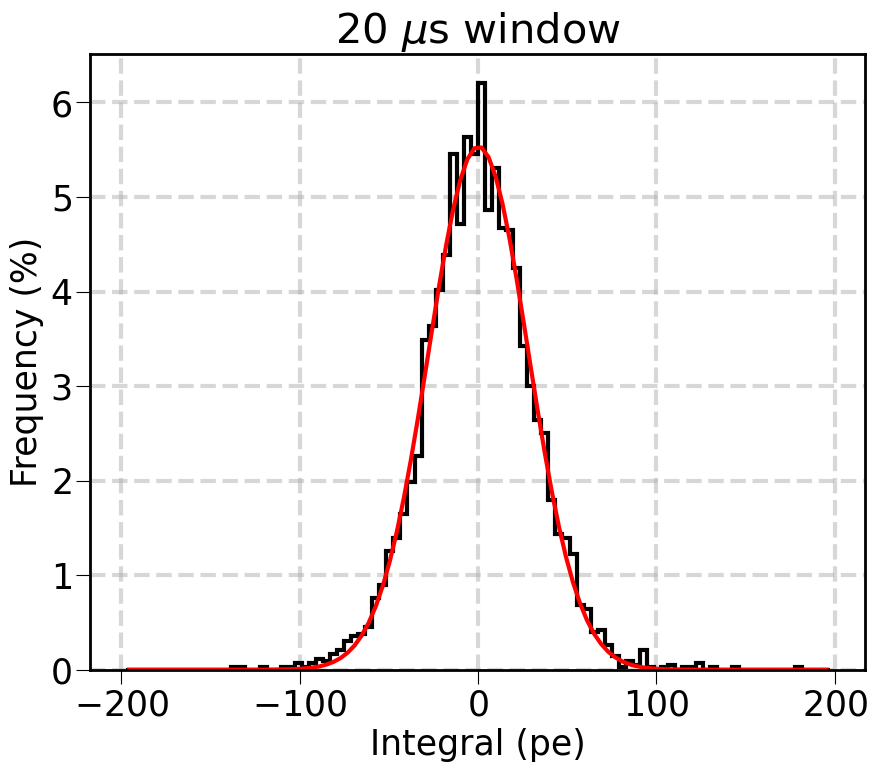

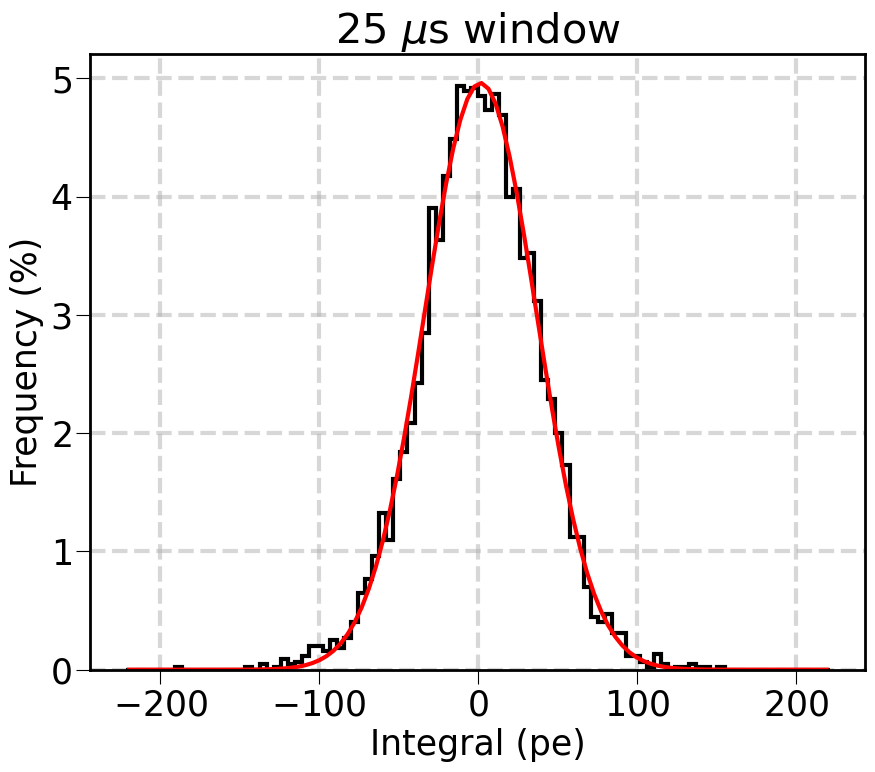

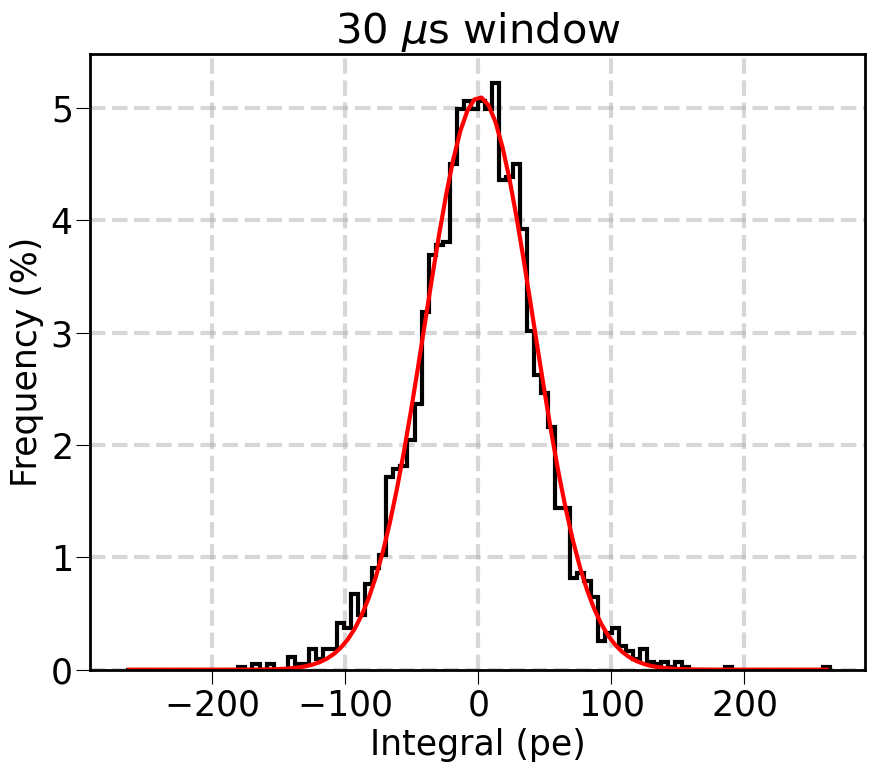

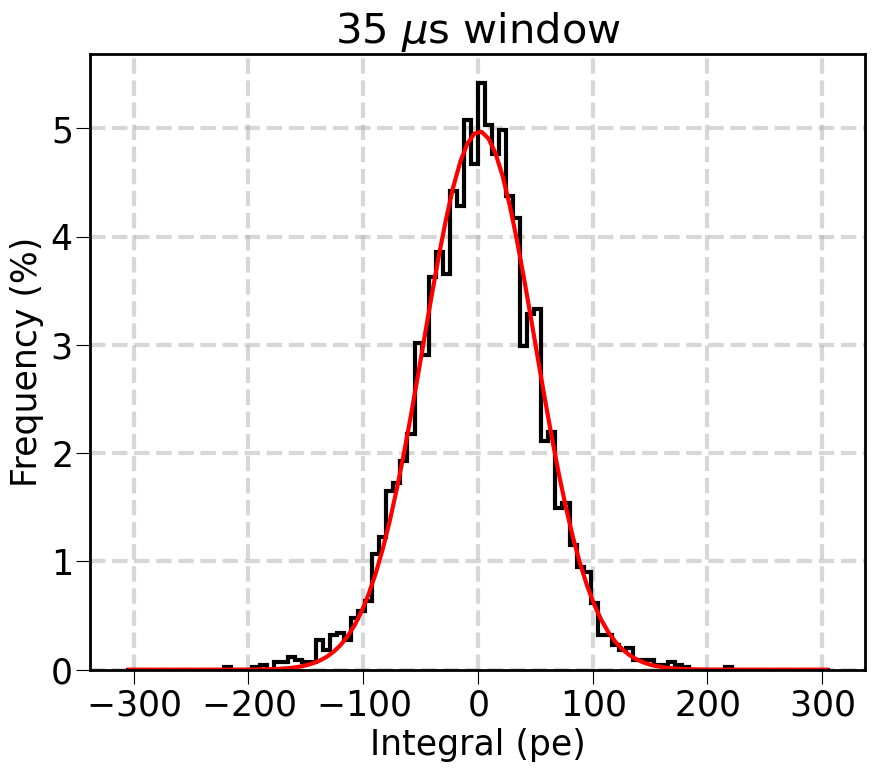

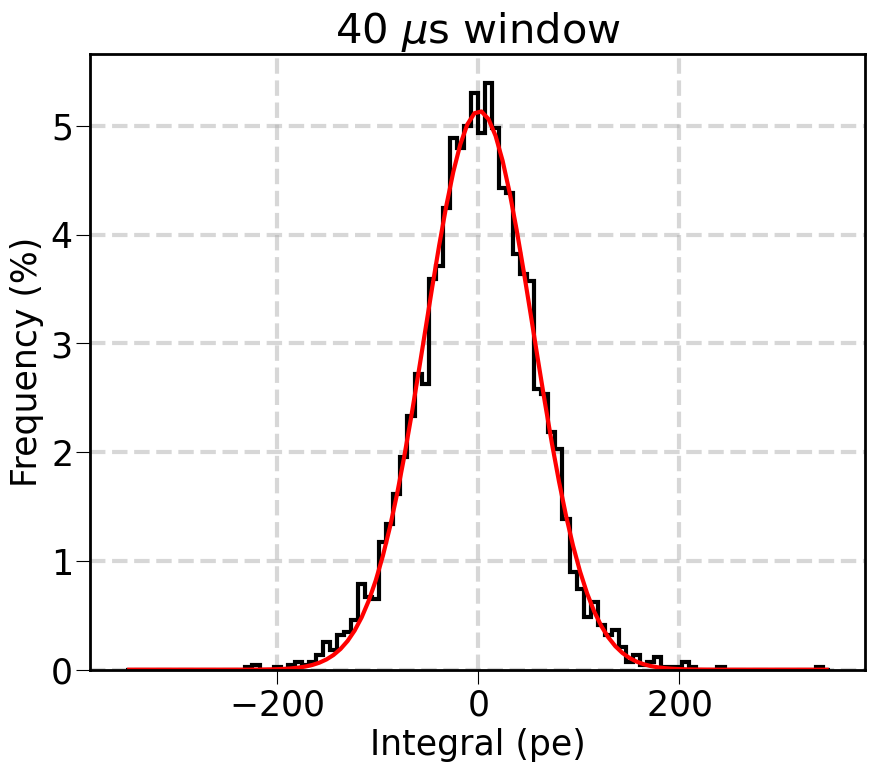

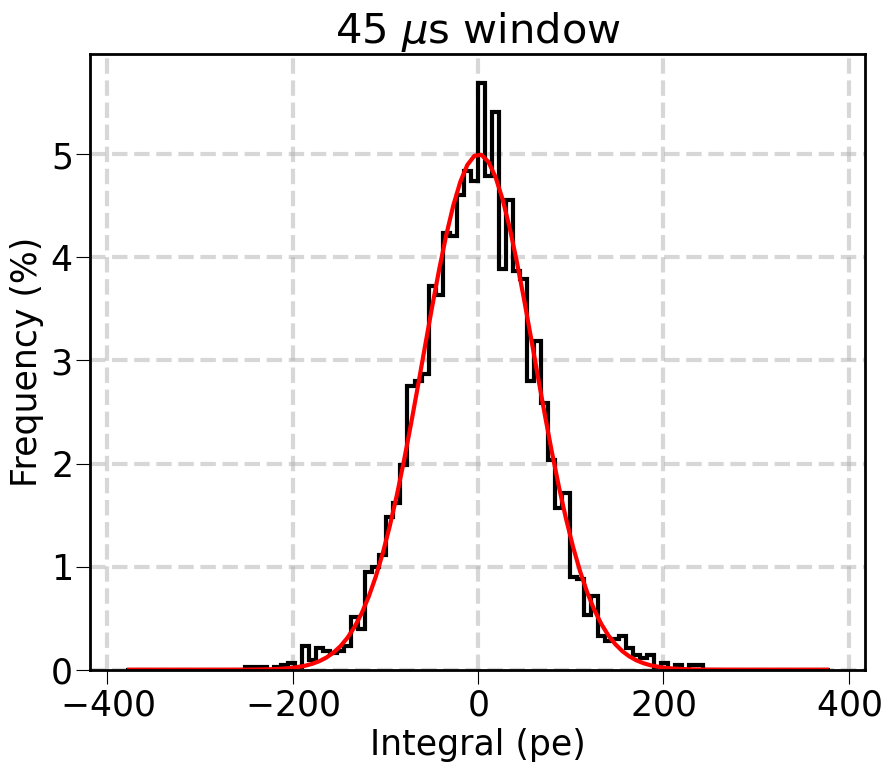

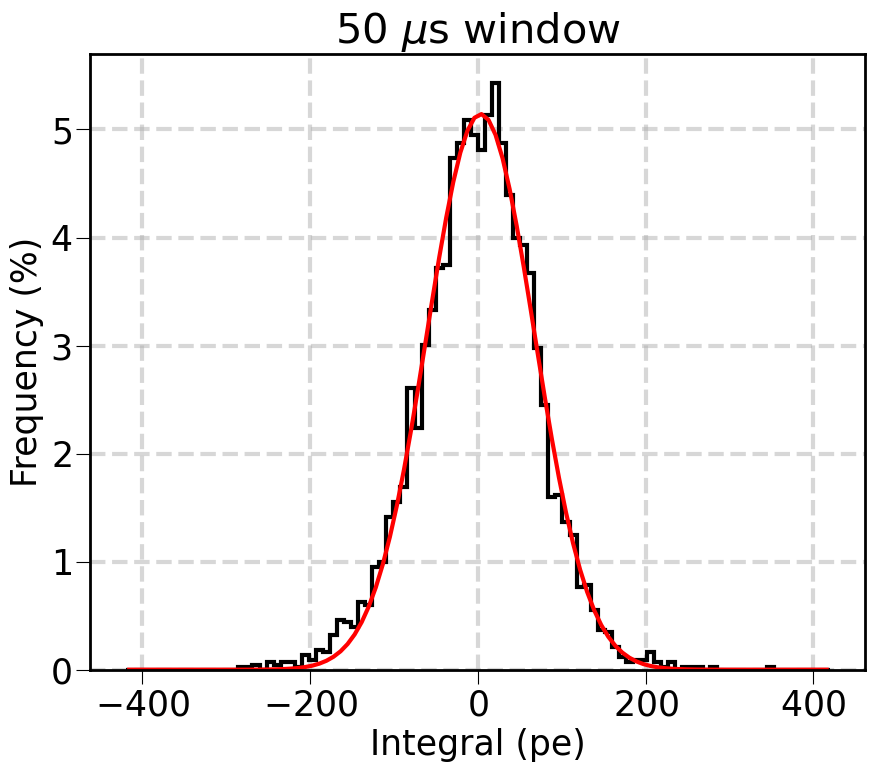

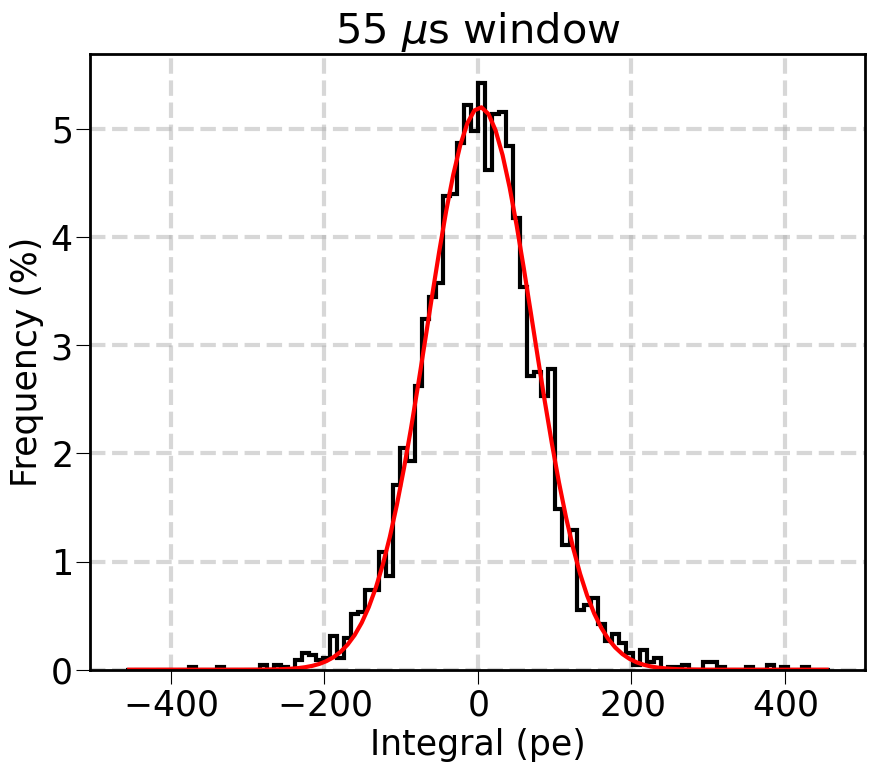

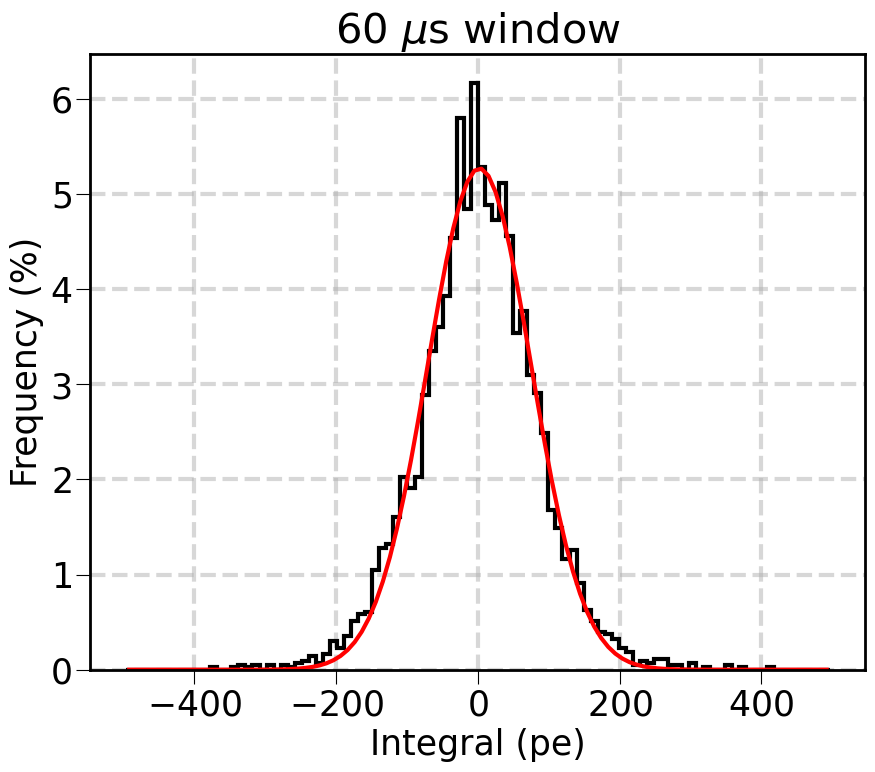

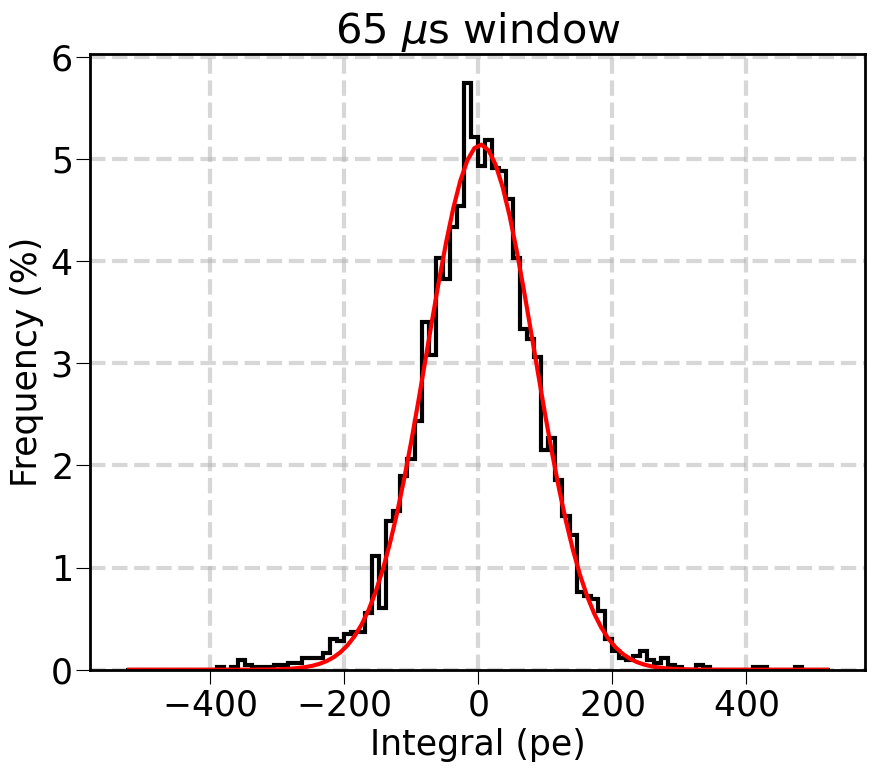

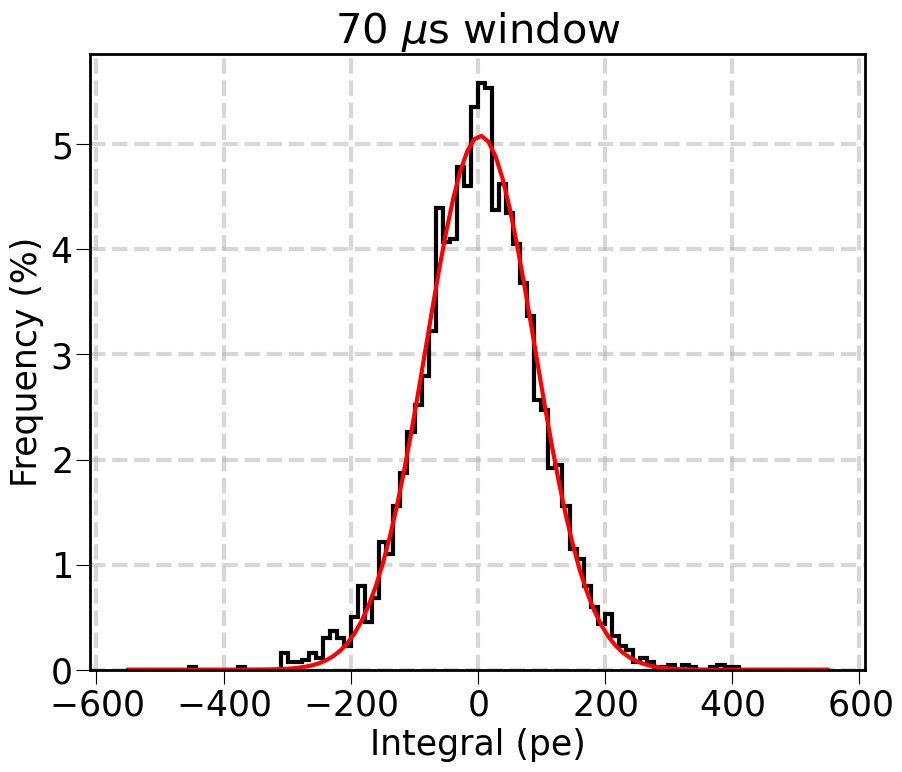

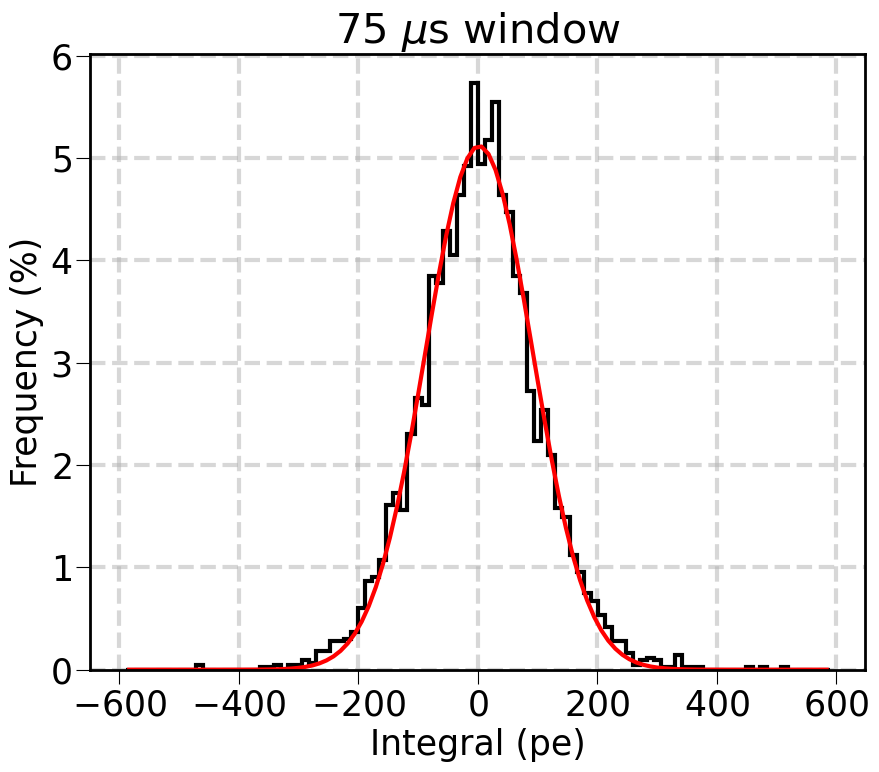

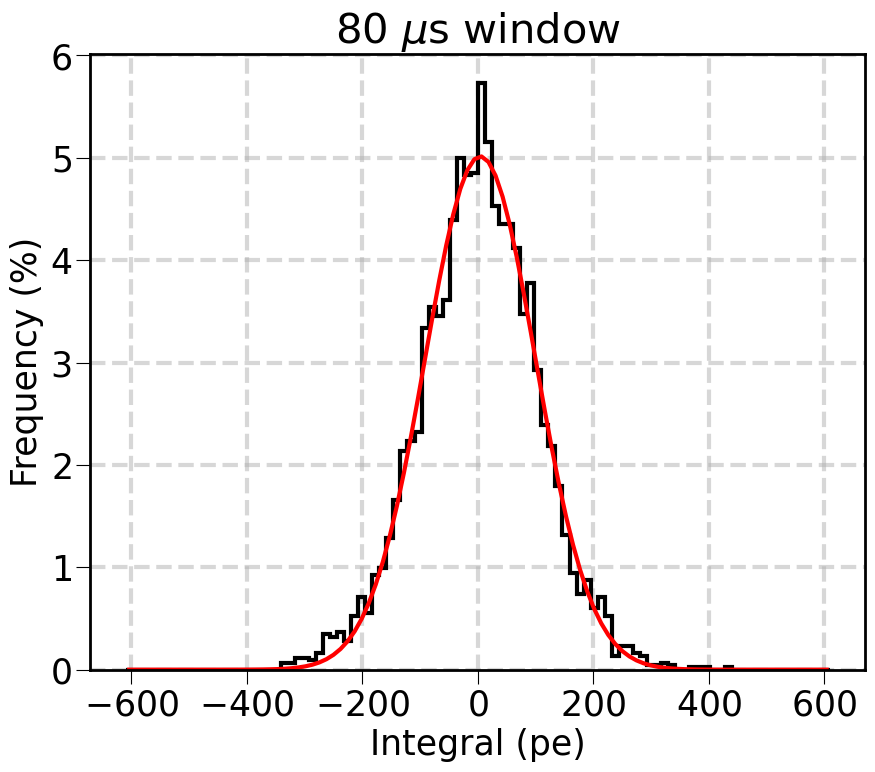

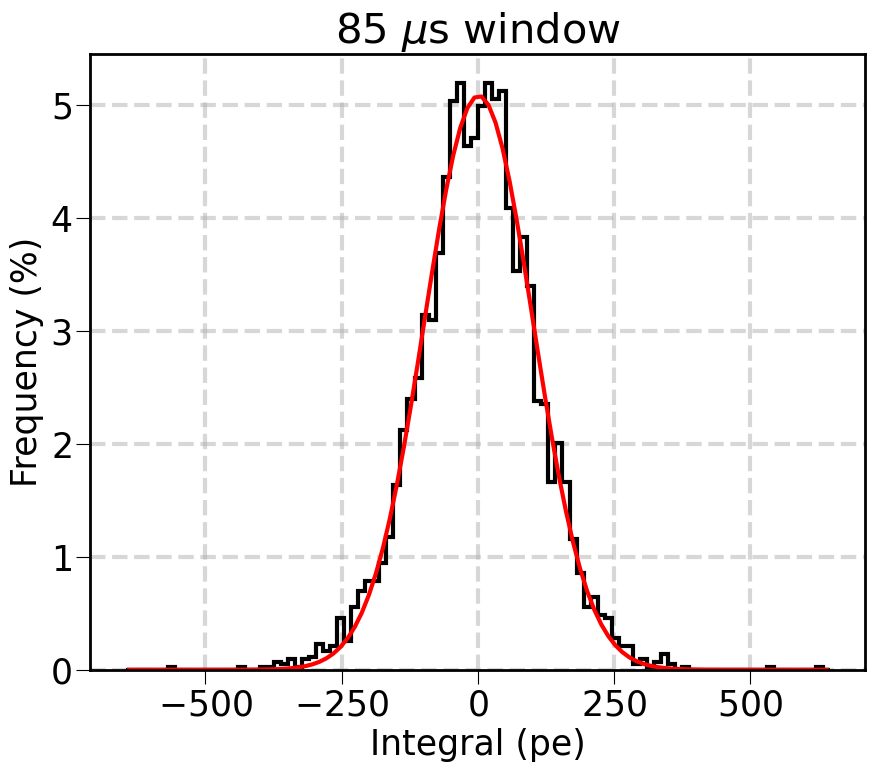

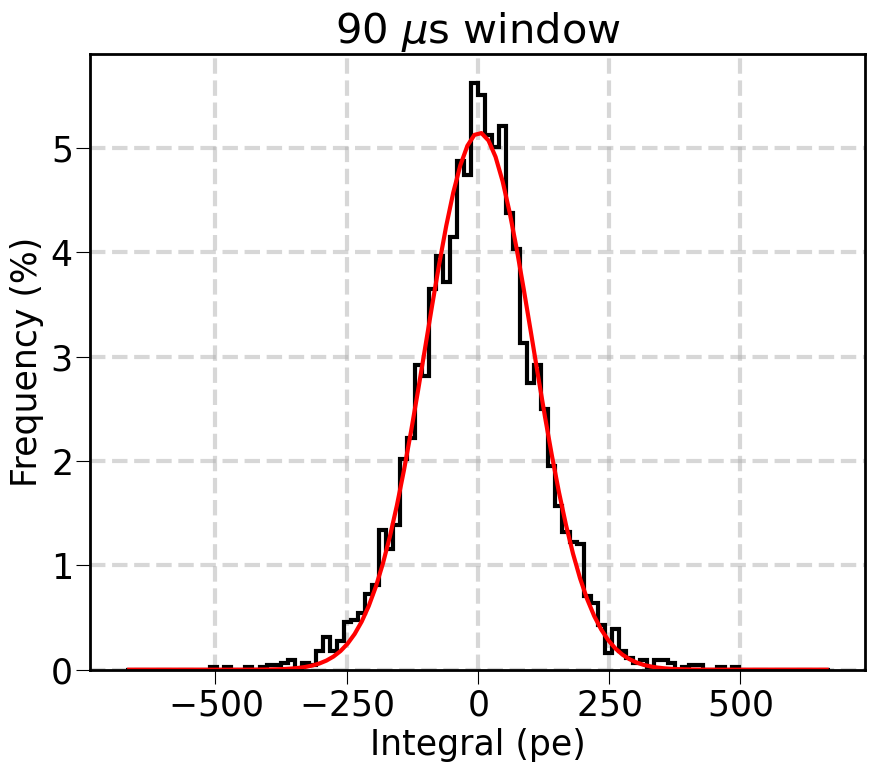

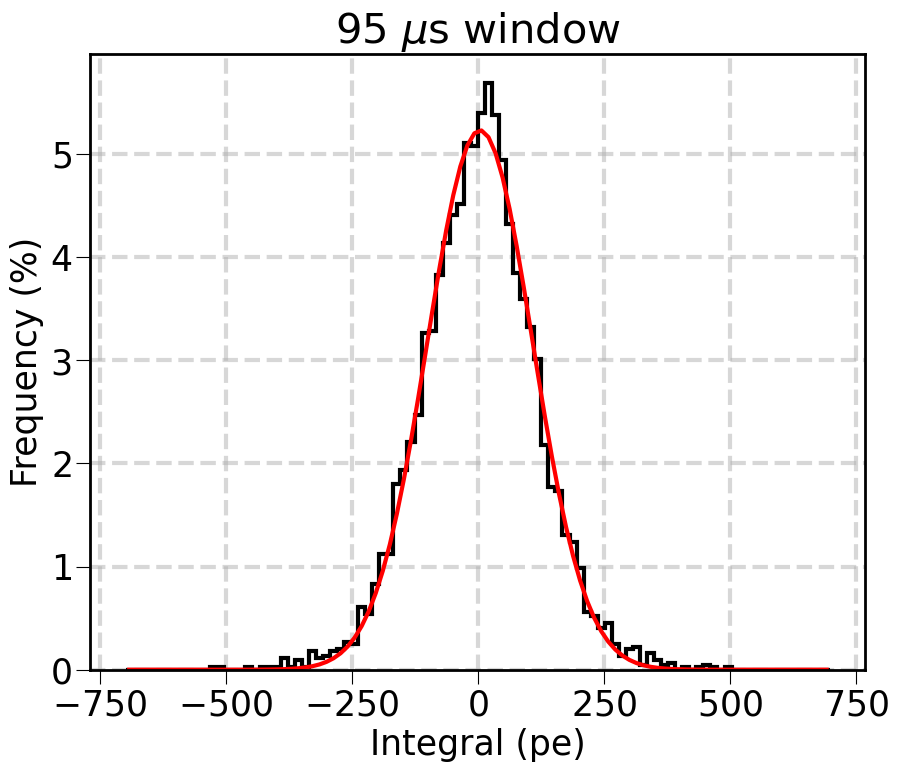

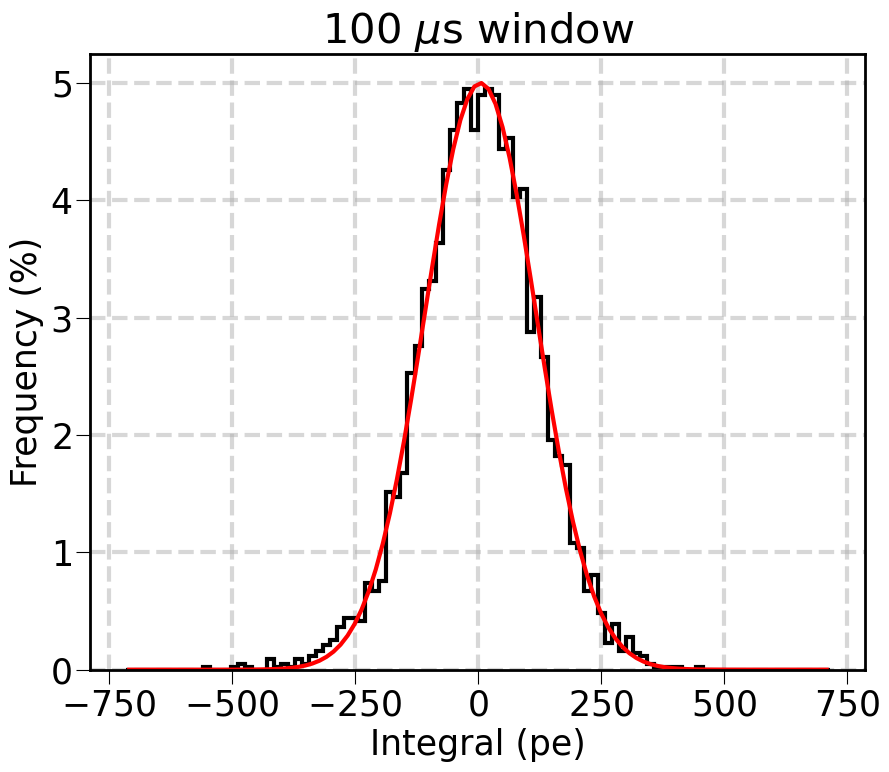

In [34]:
for sz, df in dataint.groupby("sz"):
    plt.figure()
    sig     = df.pmtsum.std()
    df      = df.loc[in_range(df.pmtsum, -6*sig, 6*sig)]
    sig     = df.pmtsum.std()
    bins    = np.linspace(-6*sig, 6*sig, 101)
    y, x, _ = normhist(df.pmtsum, bins); x = shift_to_bin_centers(x)
    f       = fit(gauss, x, y, (y.max()*2*np.pi*sig, 0, sig))
    plt.plot(x, f.fn(x), "r-")
    plt.xlabel("Integral (pe)")
    plt.ylabel("Frequency (%)")
    plt.title (f"{sz} $\mu$s window")
    plt.grid()

In [56]:
def fit_spectrum(values, pmt):
    sig  = values.std()
    df   = values[in_range(values, -6*sig, 6*sig)]
    sig  = values.std()
    bins = np.linspace(-6*sig, 6*sig, 101)
    x    = shift_to_bin_centers(bins)
    y    = np.histogram(values, bins)[0]
    f    = fit(gauss, x, y, (y.max()*2*np.pi*sig, 0, sig))
    return pd.Series(dict(pmt=pmt, mu=f.values[1], sig=f.values[2], umu=f.errors[1], usig=f.errors[2]))

def fit_noise(df):
    fits = []
    for column in filter(lambda x: "pmt" in x, df.columns):
        values = df[column]
        pmt    = int(column.split("_")[1]) if "_" in column else -1
        row    = fit_spectrum(values, pmt).to_frame().T
        fits.append(row)
    return pd.concat(fits, ignore_index=True)

noiseint = dataint.groupby("sz").apply(fit_noise).reset_index(level=1, drop=True).reset_index()
noiseint = noiseint.assign(eres=noiseint.sig / 8000 * 235, ures = noiseint.usig / 8000 * 235)

In [57]:
noiseint

,sz,pmt,mu,sig,umu,usig,eres,ures
0,1,-1.0,0.027406,1.799283,0.015893,0.015893,0.052854,0.000467
1,1,0.0,0.001793,0.172349,0.001949,0.001949,0.005063,0.000057
2,1,1.0,-0.003363,0.151352,0.001751,0.001751,0.004446,0.000051
3,1,2.0,-0.002911,0.160848,0.002097,0.002097,0.004725,0.000062
4,1,4.0,-0.002580,0.139575,0.001586,0.001586,0.004100,0.000047
...,...,...,...,...,...,...,...,...
975,100,54.0,-0.103981,6.223198,0.060540,0.060540,0.182806,0.001778
976,100,55.0,0.031827,6.963258,0.084300,0.084300,0.204546,0.002476
977,100,56.0,0.484548,6.824851,0.076103,0.076103,0.200480,0.002236
978,100,57.0,-0.010638,5.548656,0.064753,0.064754,0.162992,0.001902


In [99]:
noise1          = noiseint.iloc[0].sig
unoise1         = noiseint.iloc[0].usig
noise_expected  = windows**0.5 * noise1
unoise_expected = windows**0.5 * unoise1

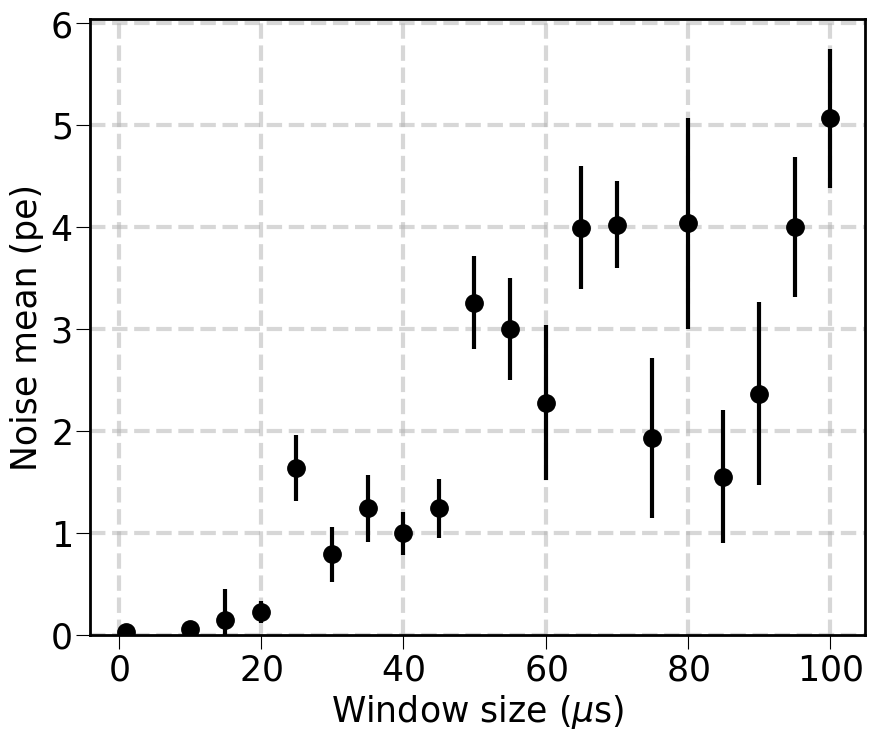

In [58]:
df = noiseint
df = df.loc[df.pmt == -1]
plt.errorbar(df.sz, df.mu, df.umu, fmt=".k")
plt.ylim(0)
plt.xlabel("Window size ($\mu$s)")
plt.ylabel("Noise mean (pe)")
plt.grid()

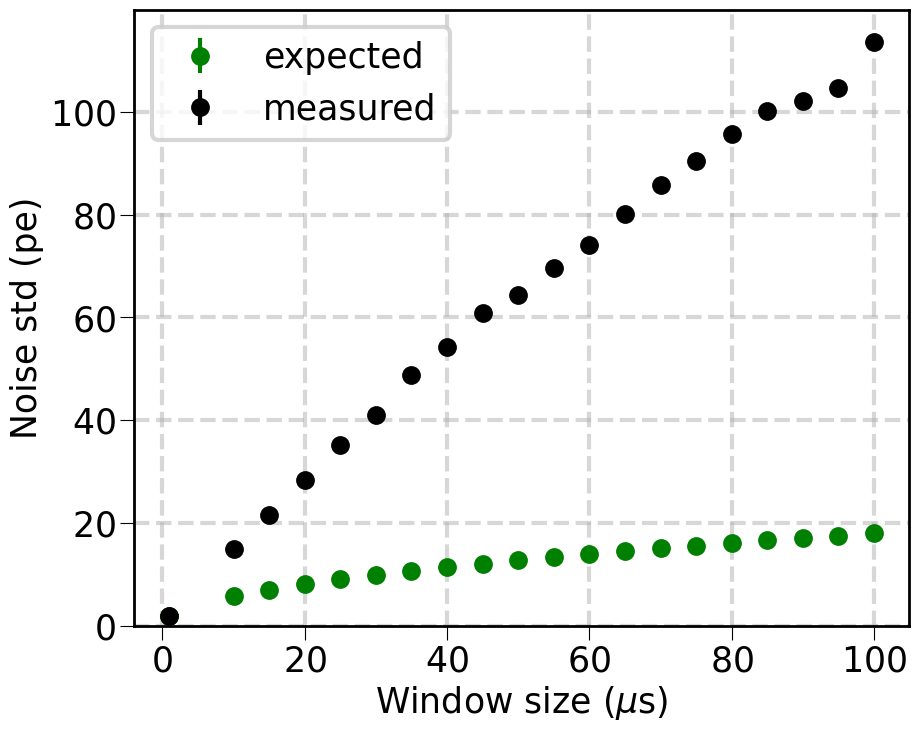

In [133]:
df = noiseint
df = df.loc[df.pmt == -1]
plt.errorbar(df.sz, noise_expected, unoise_expected, fmt=".g", label="expected")
plt.errorbar(df.sz, df.sig, df.usig, fmt=".k", label="measured")
plt.ylim(0)
plt.legend()
plt.xlabel("Window size ($\mu$s)")
plt.ylabel("Noise std (pe)")
plt.grid()

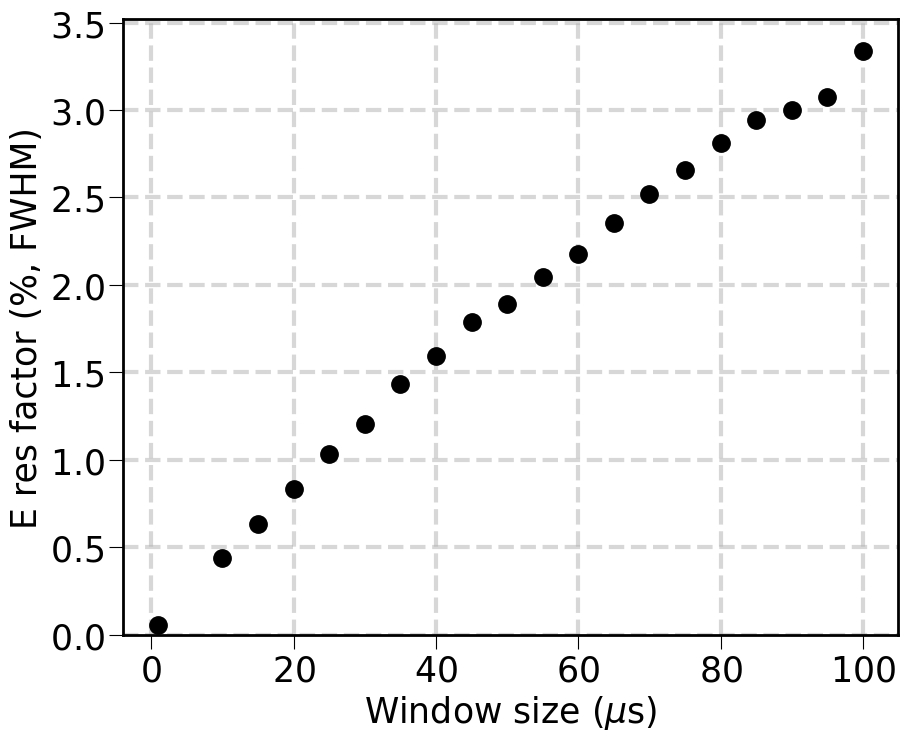

In [76]:
df = noiseint
df = df.loc[df.pmt == -1]
plt.errorbar(df.sz, df.eres, df.ures, fmt=".k")
plt.ylim(0)
plt.xlabel("Window size ($\mu$s)")
plt.ylabel("E res factor (%, FWHM)")
plt.grid()

Text(0, 0.5, 'E res factor (%, FWHM)')

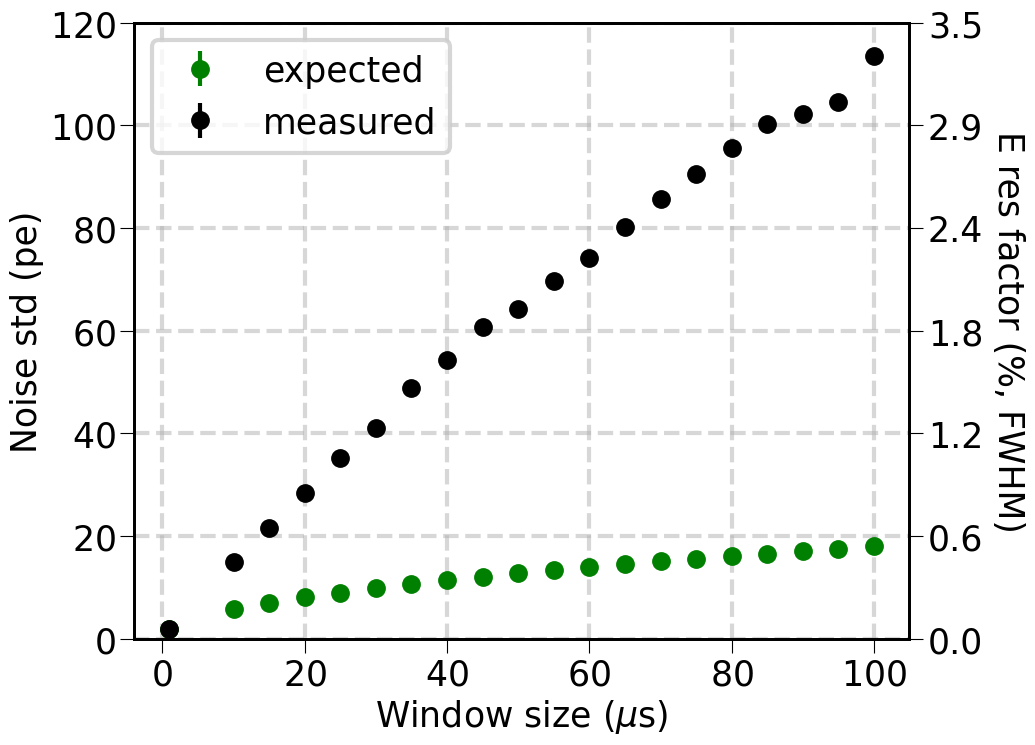

In [107]:
df = noiseint
df = df.loc[df.pmt == -1]
plt.errorbar(df.sz, noise_expected, unoise_expected, fmt=".g", label="expected")
plt.errorbar(df.sz, df.sig, df.usig, fmt=".k", label="measured")
plt.legend()
plt.xlabel("Window size ($\mu$s)")
plt.ylabel("Noise std (pe)")
plt.grid()

ylim  = 0, 120
plt.ylim(ylim)
ytick, _ = plt.yticks() 
labels   = [f"{t*235/8000:.1f}" for t in ytick]
ax = plt.gca().twinx()
ax.set_ylim(ylim)
ax.set_yticks(ytick)
ax.set_yticklabels(labels)
ax.set_ylabel("E res factor (%, FWHM)", rotation=-90, labelpad=30)

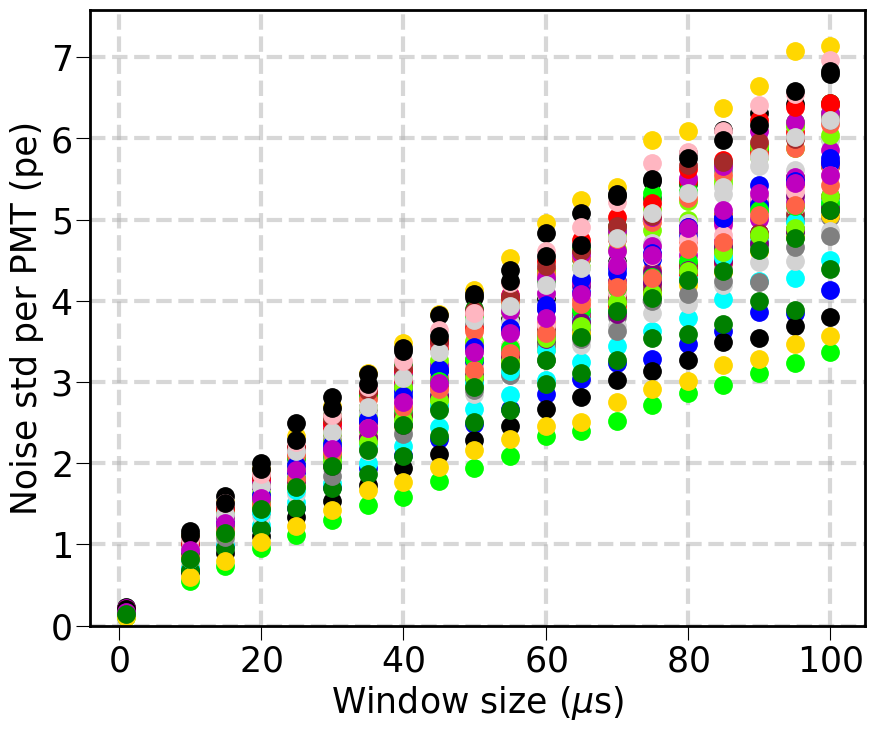

In [135]:
for pmt, df in noiseint.groupby("pmt"): 
    if pmt==-1: continue
    plt.errorbar(df.sz, df.sig, df.usig, fmt=".")
plt.ylim(0)
plt.xlabel("Window size ($\mu$s)")
plt.ylabel("Noise std per PMT (pe)")
plt.grid()

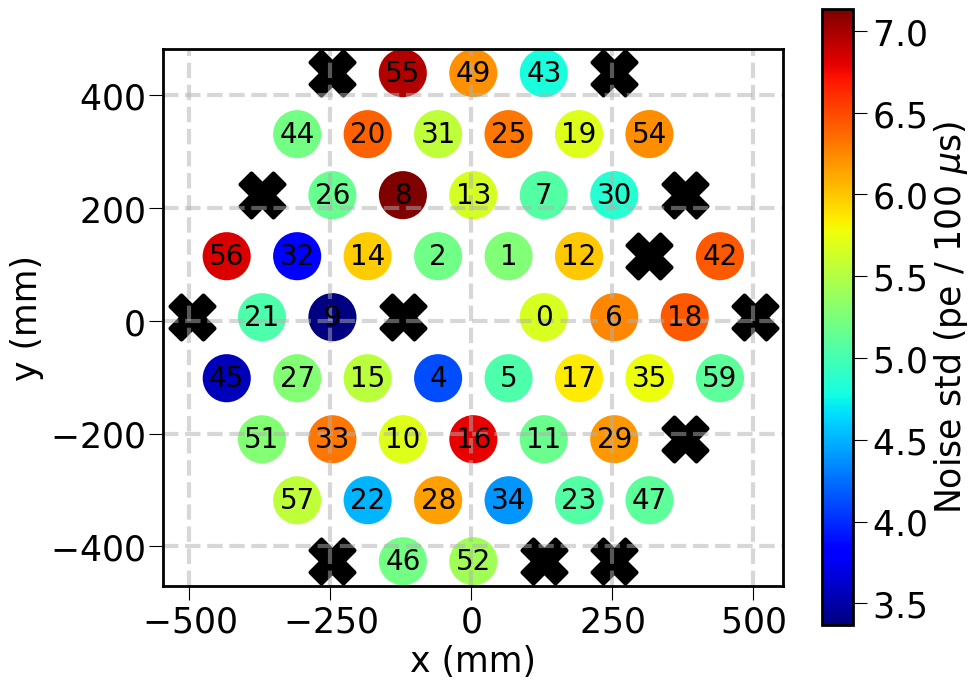

In [136]:
noise = noiseint.groupby("pmt").sig.max().iloc[1:].values
plt.scatter(maskedpmt.X, maskedpmt.Y, s=1000, c="k", marker="X")
plt.scatter(activepmt.X, activepmt.Y, s=1000, c=noise, cmap="jet")
for _, row in activepmt.iterrows():
    plt.text(row.X, row.Y, str(row.SensorID), va="center", ha="center", fontsize=20)
plt.gca().set_aspect(1)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar().set_label("Noise std (pe / 100 $\mu$s)")
plt.grid()

# Toy with white noise

Accumulating white noise should increase the std as sqrt(n), this toy is to verify it.
As input I put the noise per 25 ns sample, which is the noise in 1 mus (what I measured above) over sqrt(40) (40 25 ns samples in 1 mus).

In [127]:
noise_toy = []
noise_per_sample = 1.8/40**0.5
for i in progressbar(range(10000)):
    wf = np.random.normal(0, noise_per_sample, size=1300*40)
    t  = np.arange(len(wf)) * 25e-3

    for i in range(8):
        sz  = np.random.choice(windows)
        t0  = np.random.uniform(0, 1200)
        sel = in_range(t, t0, t0+sz)

        wfsum = wf[sel].sum()

        d = dict(sz=sz, wfsum=wfsum)
        noise_toy.append(pd.DataFrame(d, index=[0]))

noise_toy = pd.concat(noise_toy, ignore_index=True)

Item 10000 of 10000 | 0.00 s/item | ETA 0.0 min | Ellapsed 0.7 min


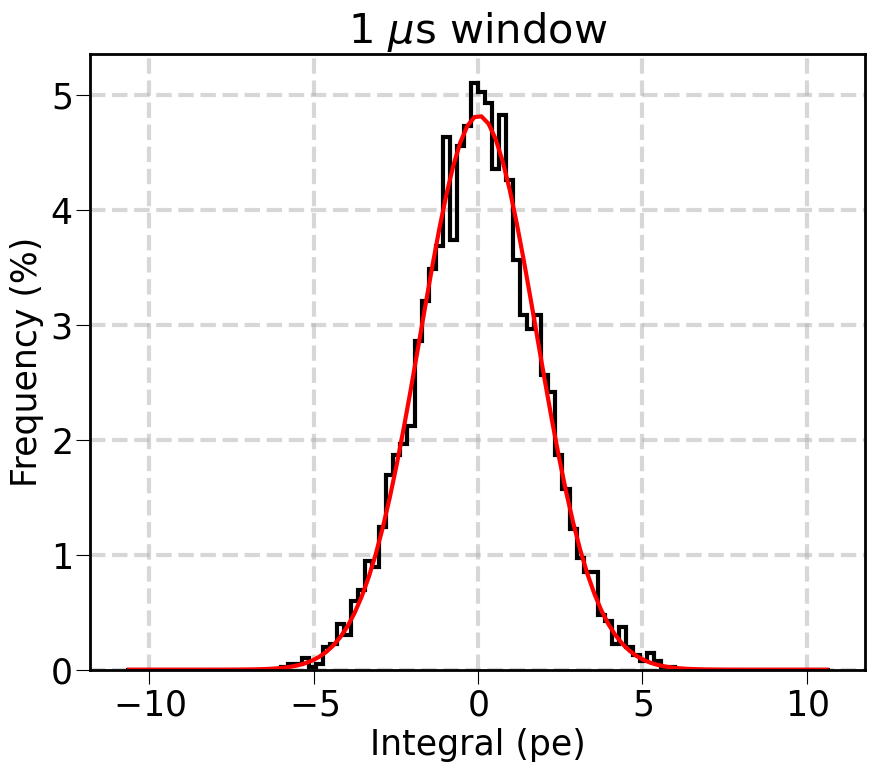

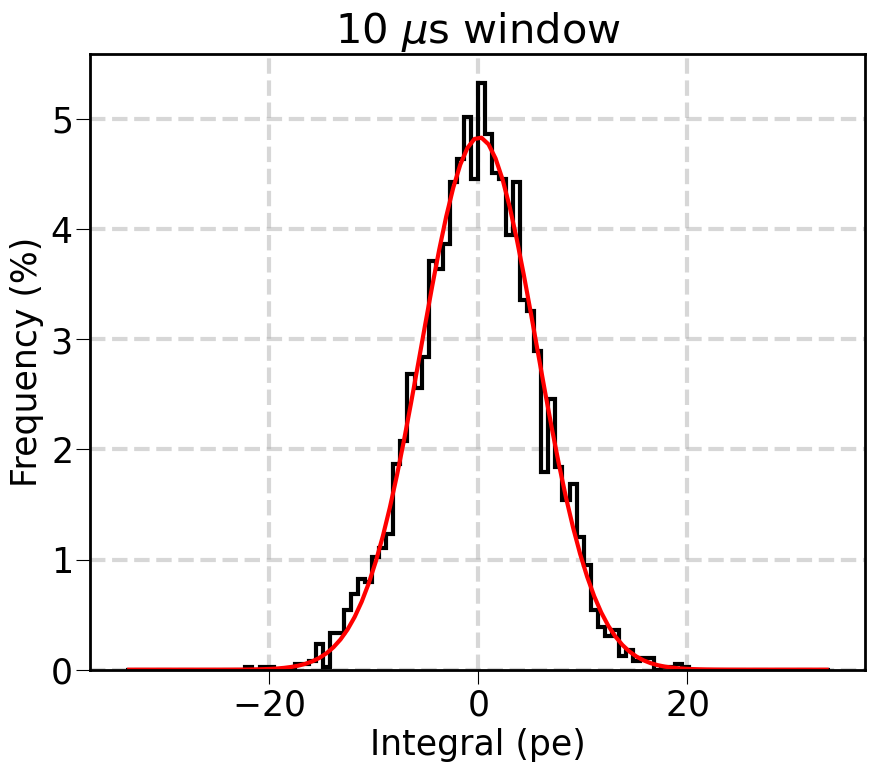

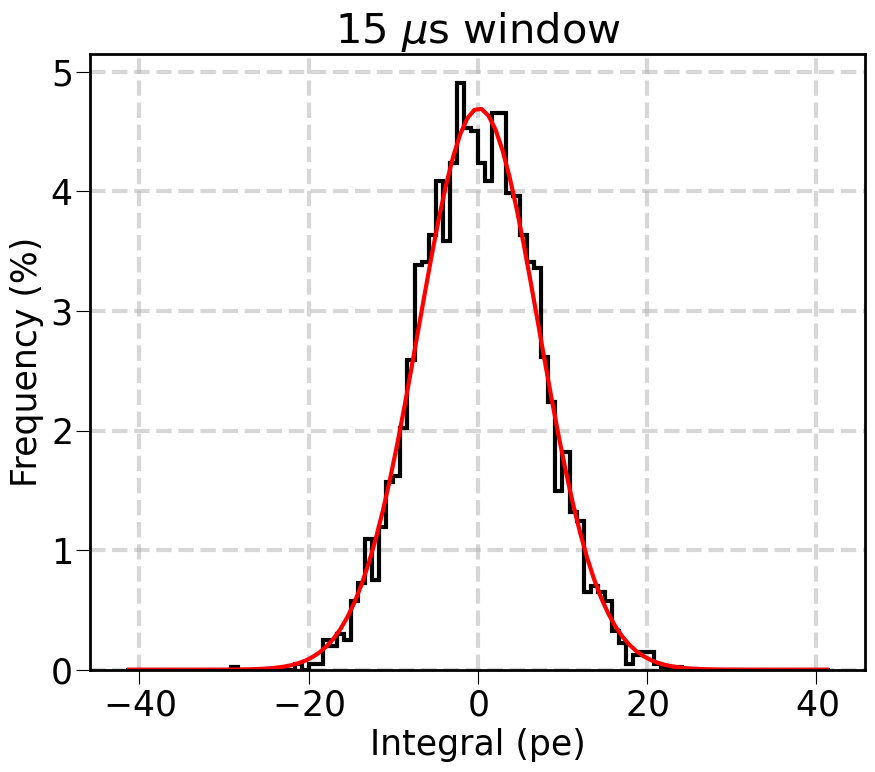

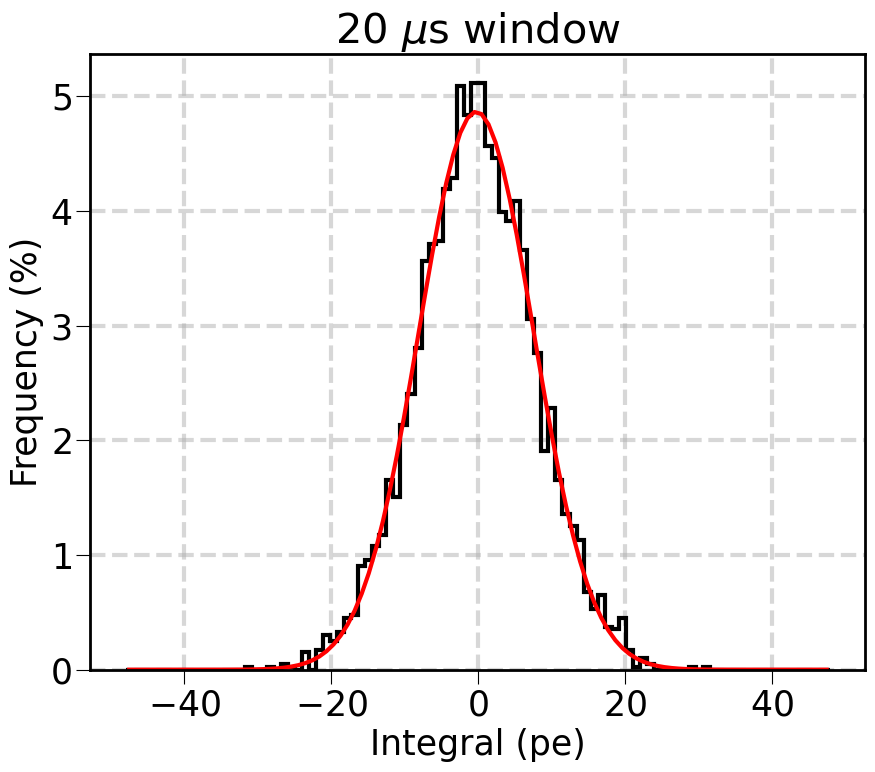

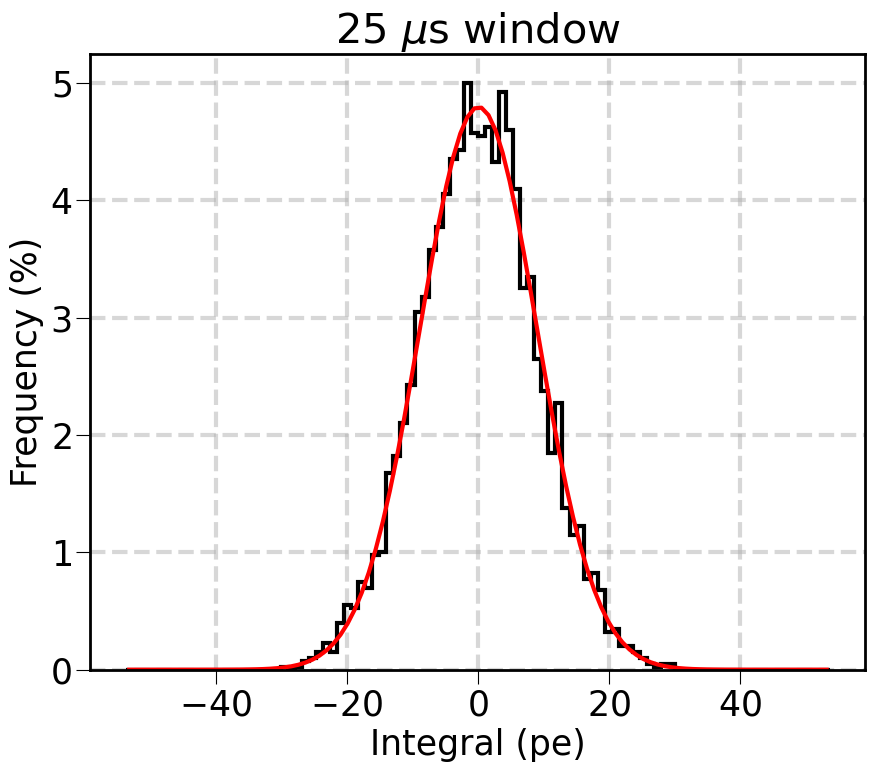

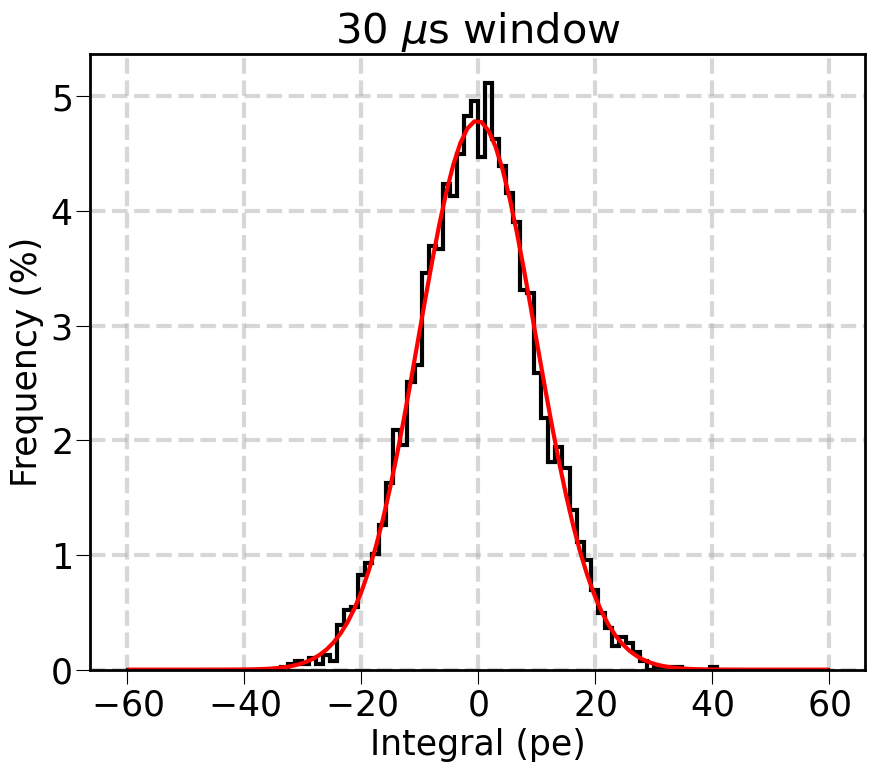

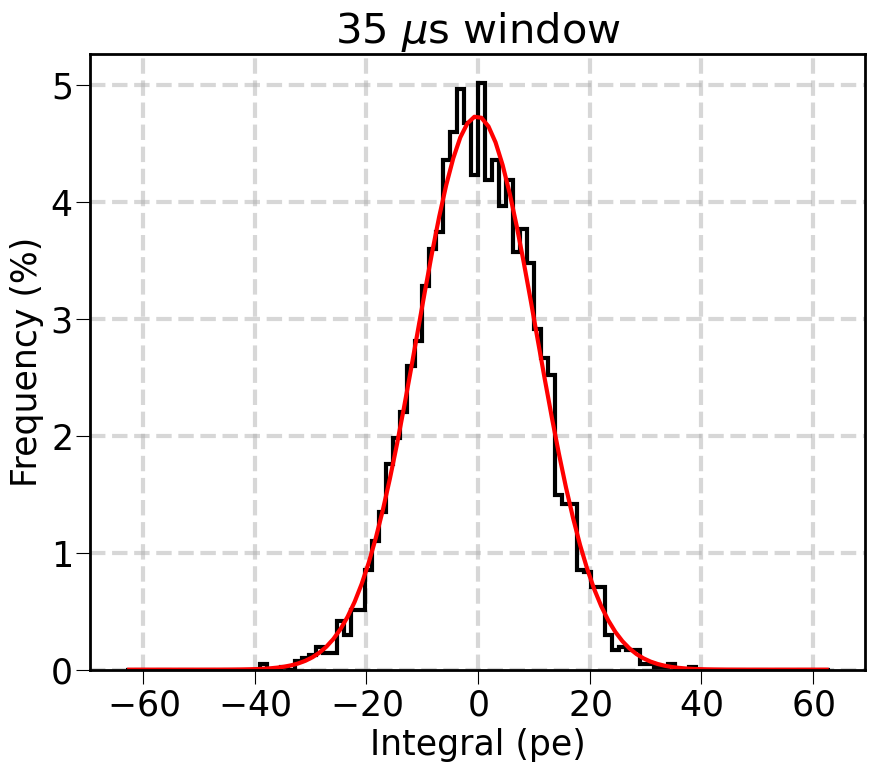

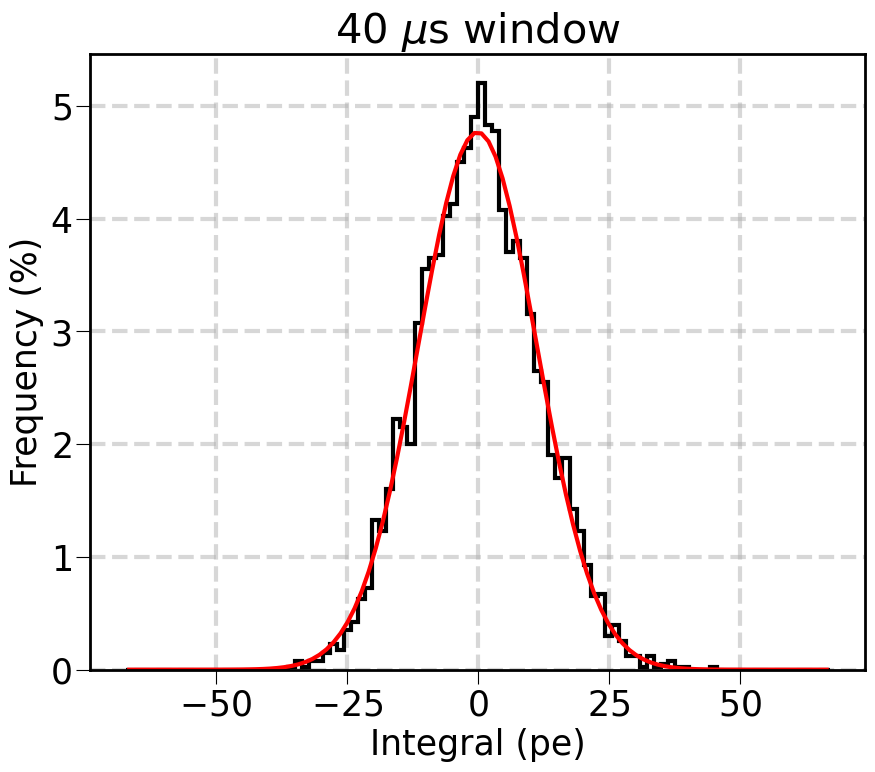

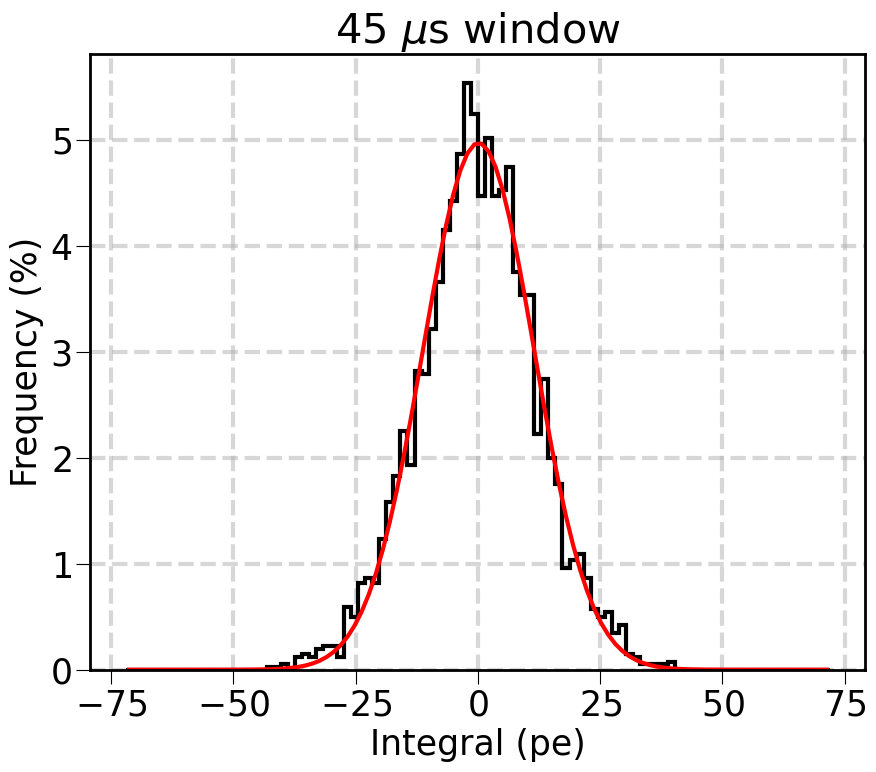

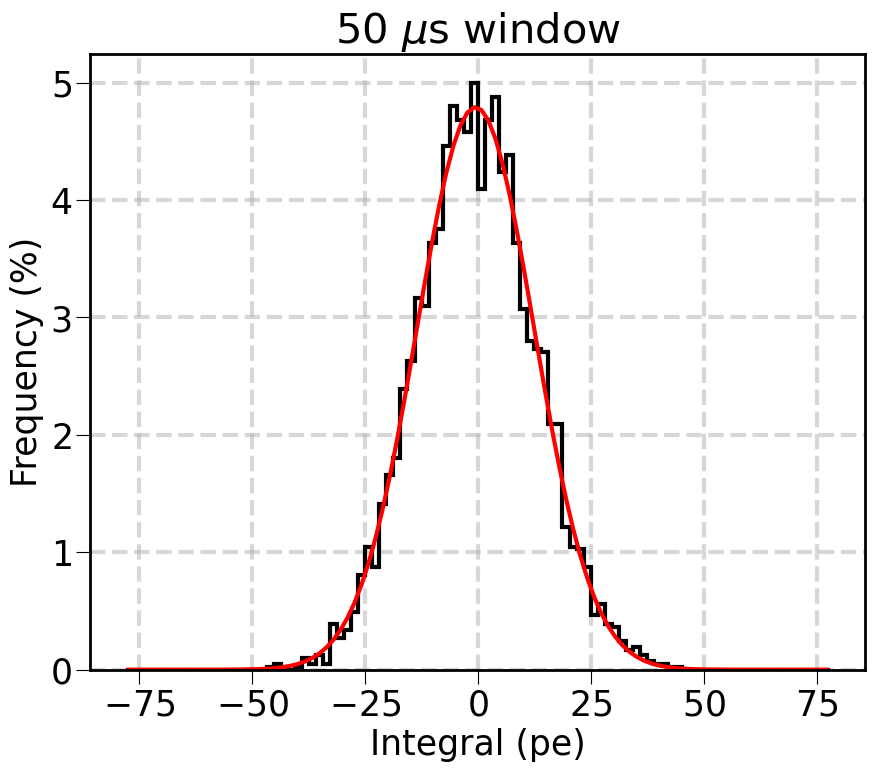

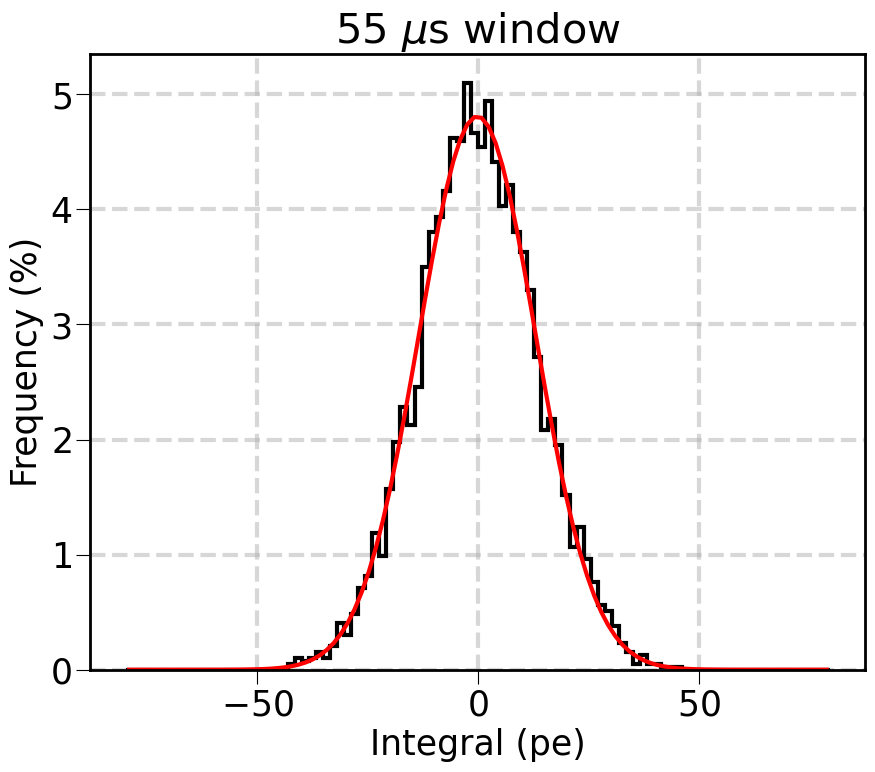

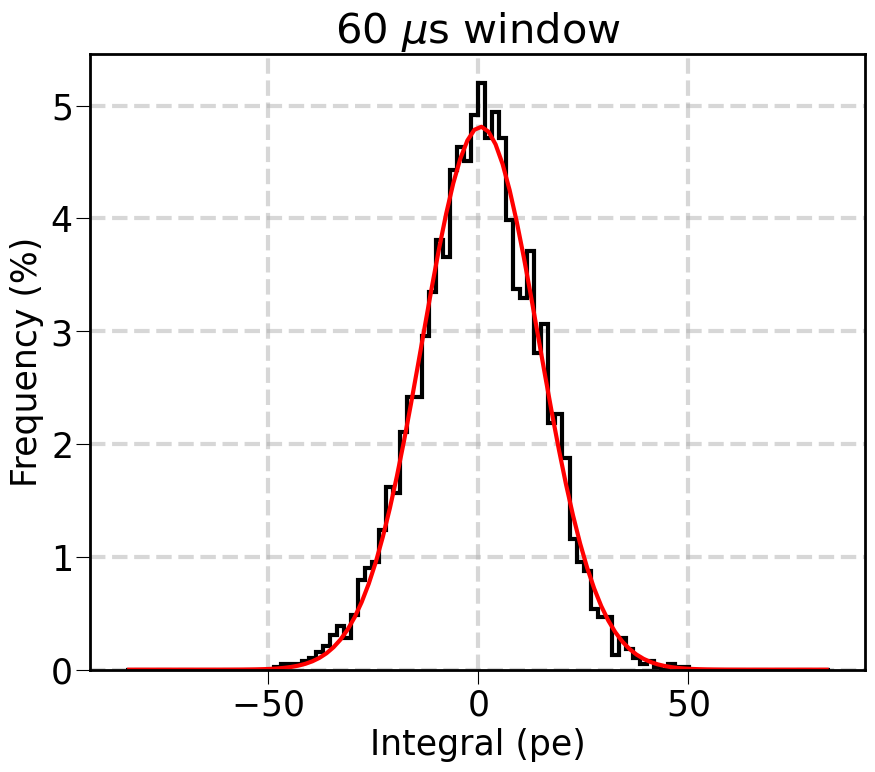

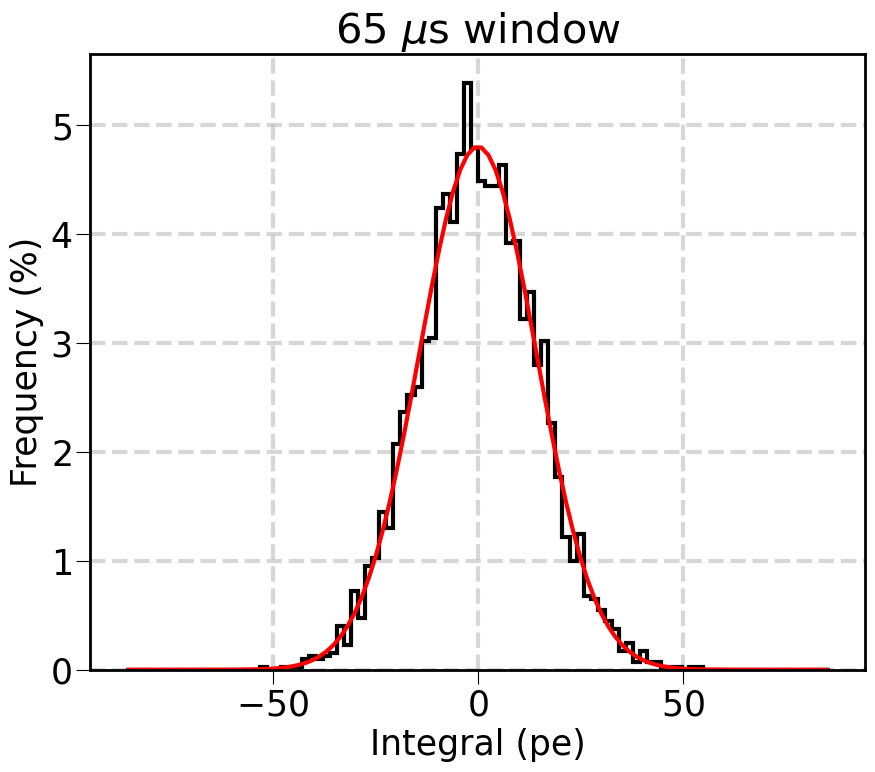

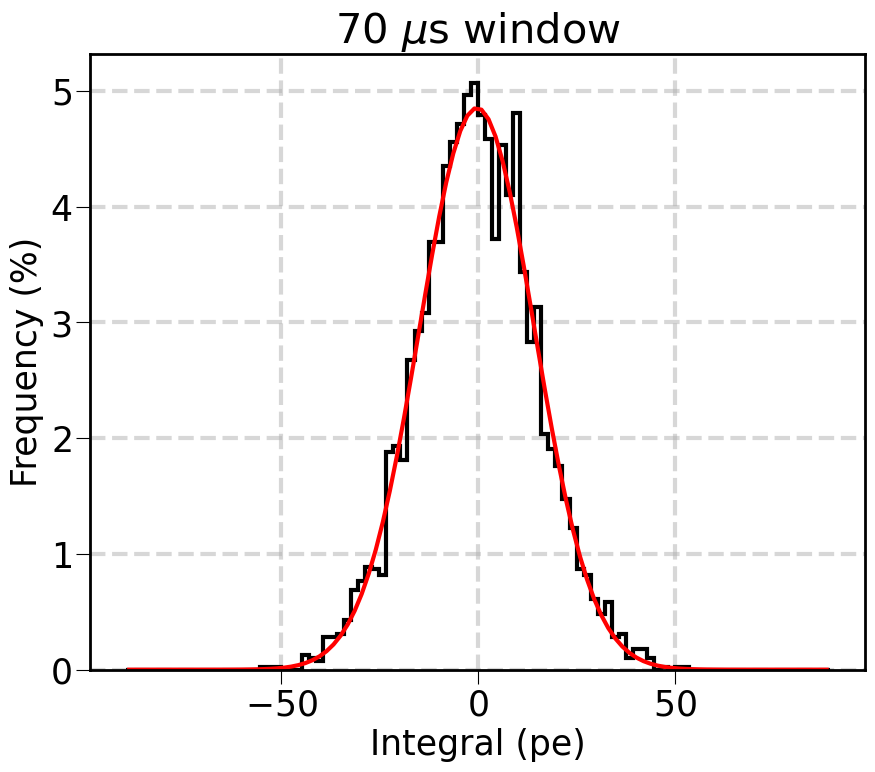

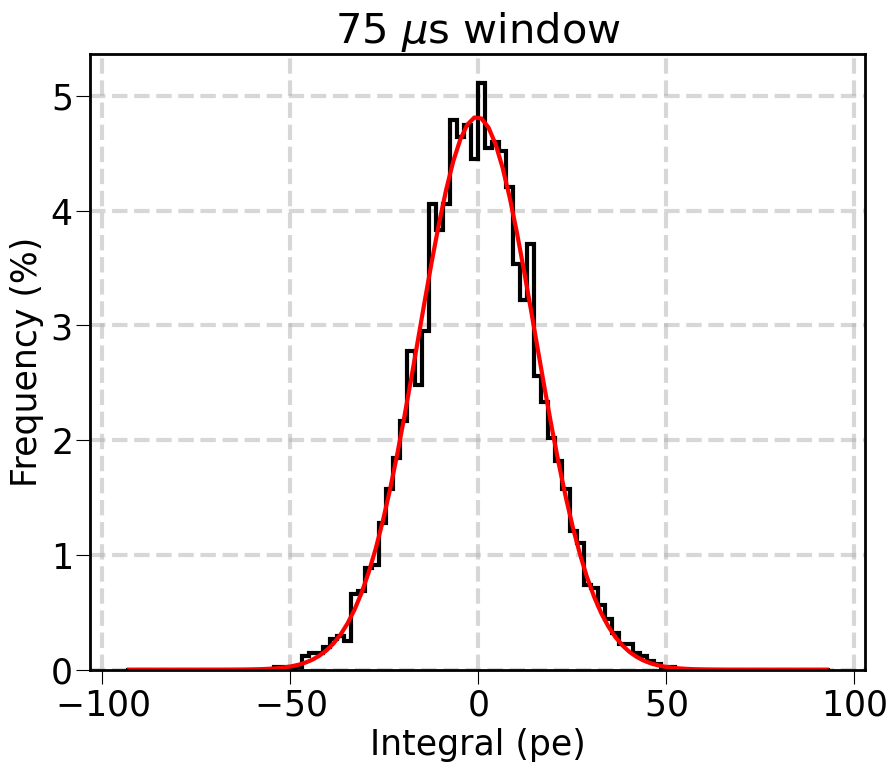

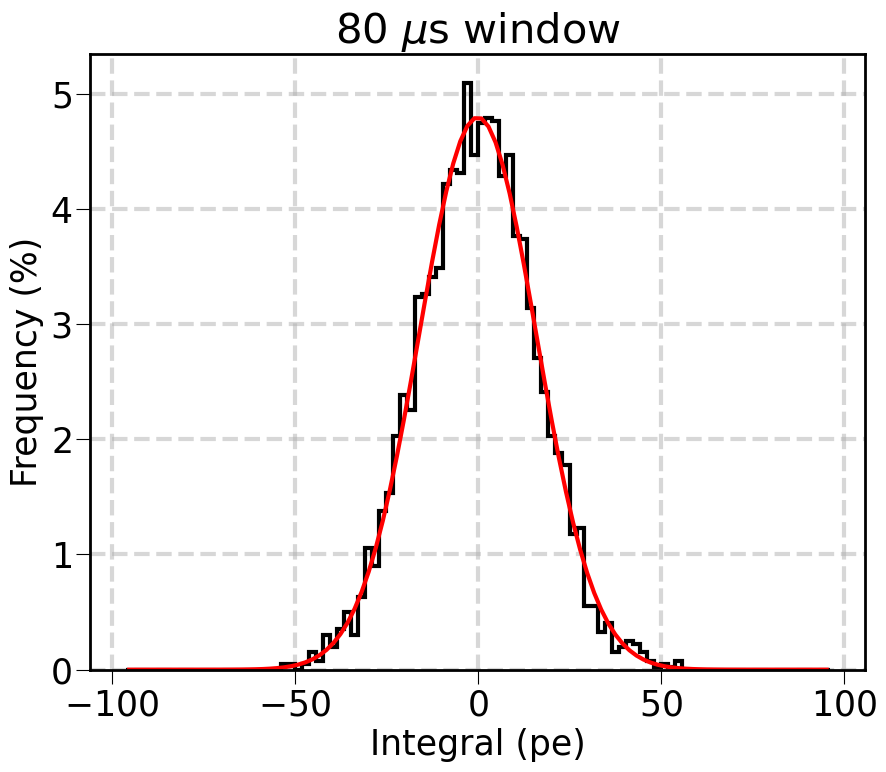

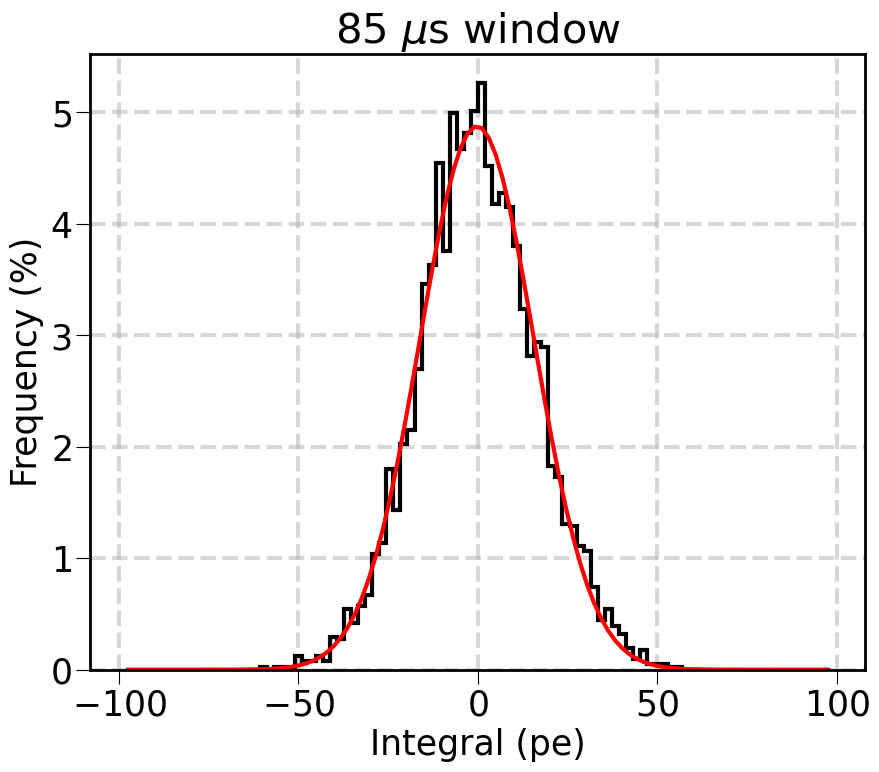

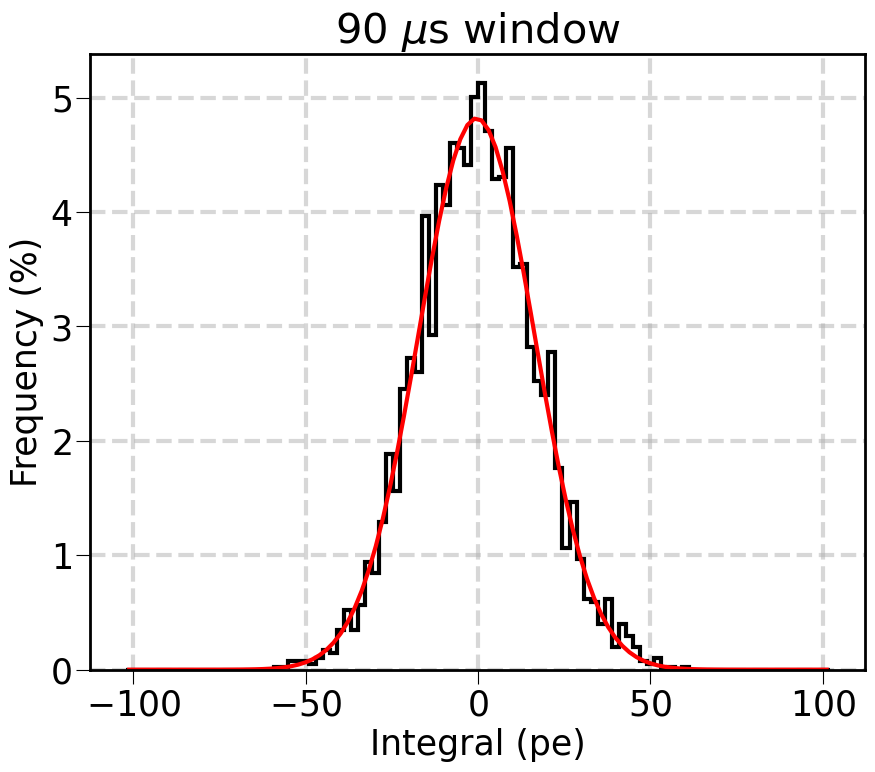

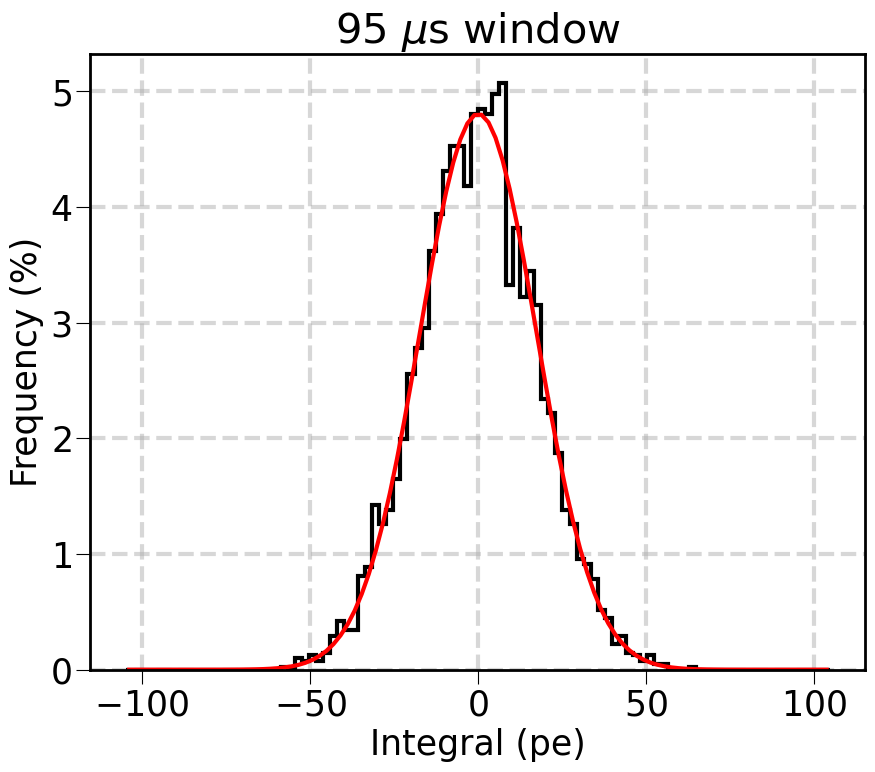

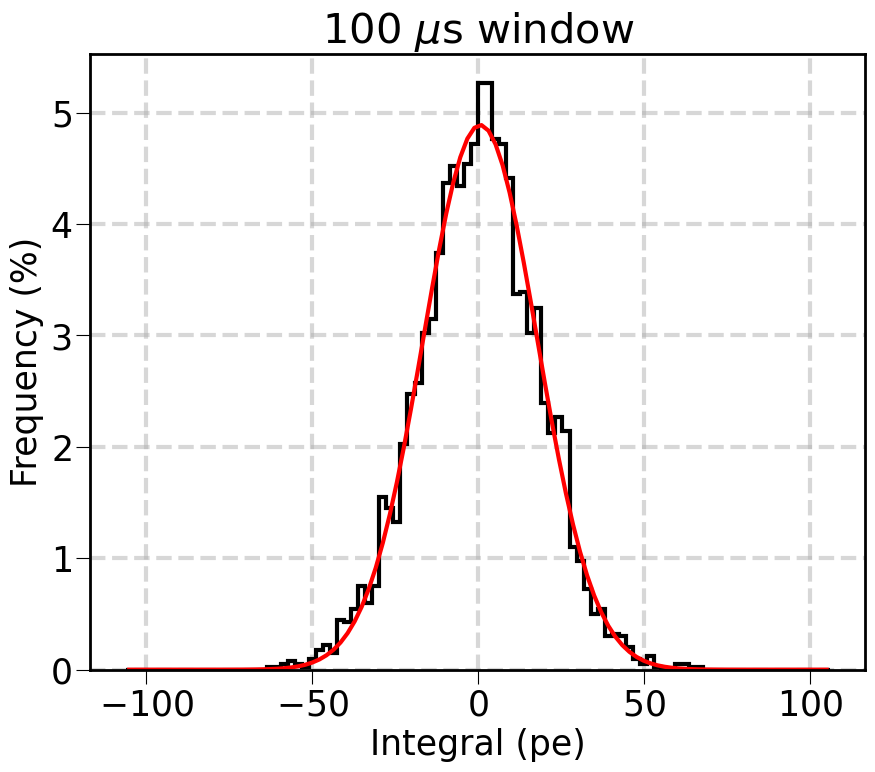

In [128]:
for sz, df in noise_toy.groupby("sz"):
    plt.figure()
    sig     = df.wfsum.std()
    df      = df.loc[in_range(df.wfsum, -6*sig, 6*sig)]
    sig     = df.wfsum.std()
    bins    = np.linspace(-6*sig, 6*sig, 101)
    y, x, _ = normhist(df.wfsum, bins); x = shift_to_bin_centers(x)
    f       = fit(gauss, x, y, (y.max()*2*np.pi*sig, 0, sig))
    plt.plot(x, f.fn(x), "r-")
    plt.xlabel("Integral (pe)")
    plt.ylabel("Frequency (%)")
    plt.title (f"{sz} $\mu$s window")
    plt.grid()

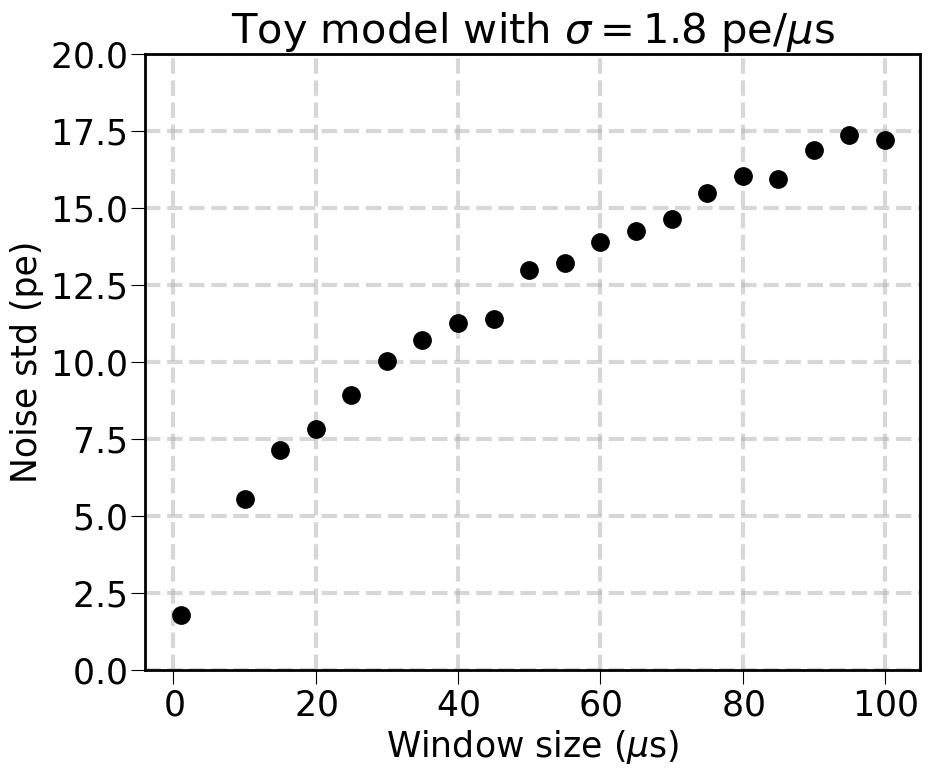

In [143]:
df = noise_toy.groupby("sz").apply(lambda x: fit_spectrum(x.wfsum.values, -1)).reset_index()
plt.errorbar(df.sz, df.sig, df.usig, fmt=".k")
plt.ylim(0, 20)
plt.xlabel("Window size ($\mu$s)")
plt.ylabel("Noise std (pe)")
plt.title("Toy model with $\sigma = 1.8$ pe/$\mu$s")
plt.grid()